In [2]:
import pickle
from random import choice
from itertools import chain

# Load the Knowledge Graph from dbpedia.pickle
with open('E:\dbpedia_2015_undirected_light.pickle', 'rb') as file:
    dbpedia = pickle.load(file)


In [6]:
import random
class KG():
    def __init__(self, kg):
        super().__init__()
        self.kg = kg
        
    def get_one_hop_subgraph(self, entity):
        """
        Extract the one-hop and two-hop subgraph for the given entity.
    
        Args:
            entity (str): The entity for which to extract the subgraph.
    
        Returns:
            dict: A dictionary with keys 'one_hop' and 'two_hop', containing the respective neighbors.
        """
        subgraph = {}

    # First-hop neighbors
        
        if entity in self.kg:
            for rel,tails in self.kg[entity].items():
                subgraph[rel]=tails
            
        return subgraph


In [7]:
kg = KG(dbpedia)

In [1]:
import pickle
import random

# Load the full training set from the pickle file
with open('E:\\nlp_lab\\data\\factkg_train.pickle', 'rb') as file:
    test_smallset = pickle.load(file)

# Randomly select 20,000 claim-information pairs
random.seed(42)  # Set a seed for reproducibility
selected_keys = random.sample(list(test_smallset.keys()), 20000)

# Create a smaller dictionary containing only the selected keys
selected_data = {key: test_smallset[key] for key in selected_keys}

# Split the selected data into 10 parts
part_size = len(selected_data) // 10  # Size of each part (2,000 in this case)
parts = []

keys = list(selected_data.keys())
start = 0
for i in range(10):
    end = start + part_size
    # Handle any leftover keys in the last part
    if i == 9:
        end = len(selected_data)
    part = {key: selected_data[key] for key in keys[start:end]}
    parts.append(part)
    start = end

# Save each part into separate pickle files
for i, part in enumerate(parts):
    with open(f'E://training_data_part_{i+1}.pickle', 'wb') as file:
        pickle.dump(part, file)

    print(f"Part {i+1}: Saved {len(part)} items to 'training_data_part_{i+1}.pickle'")


Part 1: Saved 2000 items to 'training_data_part_1.pickle'
Part 2: Saved 2000 items to 'training_data_part_2.pickle'
Part 3: Saved 2000 items to 'training_data_part_3.pickle'
Part 4: Saved 2000 items to 'training_data_part_4.pickle'
Part 5: Saved 2000 items to 'training_data_part_5.pickle'
Part 6: Saved 2000 items to 'training_data_part_6.pickle'
Part 7: Saved 2000 items to 'training_data_part_7.pickle'
Part 8: Saved 2000 items to 'training_data_part_8.pickle'
Part 9: Saved 2000 items to 'training_data_part_9.pickle'
Part 10: Saved 2000 items to 'training_data_part_10.pickle'


In [4]:
import pickle
import random

# Load the full training set from the pickle file
with open('E:\\nlp_lab\\data\\factkg_dev.pickle', 'rb') as file:
    dev_smallset = pickle.load(file)

# Randomly select 20,000 claim-information pairs
random.seed(42)  # Set a seed for reproducibility
selected_keys = random.sample(list(dev_smallset.keys()), 3200)

# Create a smaller dictionary containing only the selected keys
selected_data = {key: dev_smallset[key] for key in selected_keys}

# Split the selected data into 10 parts
part_size = len(selected_data) // 2  # Size of each part (2,000 in this case)
parts = []

keys = list(selected_data.keys())
start = 0
for i in range(2):
    end = start + part_size
    # Handle any leftover keys in the last part
    if i == 1:
        end = len(selected_data)
    part = {key: selected_data[key] for key in keys[start:end]}
    parts.append(part)
    start = end

# Save each part into separate pickle files
for i, part in enumerate(parts):
    with open(f'E://dev_data_part_{i+1}.pickle', 'wb') as file:
        pickle.dump(part, file)

    print(f"Part {i+1}: Saved {len(part)} items to 'dev_data_part_{i+1}.pickle'")


Part 1: Saved 1600 items to 'dev_data_part_1.pickle'
Part 2: Saved 1600 items to 'dev_data_part_2.pickle'


In [5]:
import pickle
import random

# Load the full training set from the pickle file
with open('E:\\nlp_lab\\data\\factkg_test.pickle', 'rb') as file:
    test_smallset = pickle.load(file)

# Randomly select 20,000 claim-information pairs
random.seed(42)  # Set a seed for reproducibility
selected_keys = random.sample(list(test_smallset.keys()),2200)

# Create a smaller dictionary containing only the selected keys
selected_data = {key: test_smallset[key] for key in selected_keys}

# Split the selected data into 10 parts
part_size = len(selected_data) // 2  # Size of each part (2,000 in this case)
parts = []

keys = list(selected_data.keys())
start = 0
for i in range(2):
    end = start + part_size
    # Handle any leftover keys in the last part
    if i == 1:
        end = len(selected_data)
    part = {key: selected_data[key] for key in keys[start:end]}
    parts.append(part)
    start = end

# Save each part into separate pickle files
for i, part in enumerate(parts):
    with open(f'E://test_data_part_{i+1}.pickle', 'wb') as file:
        pickle.dump(part, file)

    print(f"Part {i+1}: Saved {len(part)} items to 'test_data_part_{i+1}.pickle'")


Part 1: Saved 1100 items to 'test_data_part_1.pickle'
Part 2: Saved 1100 items to 'test_data_part_2.pickle'


In [16]:
import pickle
from random import choice
from itertools import chain

# Process all entities and save two-hop neighbors
for i in range(10):
    with open(f'E://training_data_part_{i+1}.pickle', 'rb') as file:
        test_pedia = pickle.load(file)
    #for rel_2, tail_2 in random.sample(list(self.kg[tail].items()), min(len(self.kg[tail]), 2)):
    evidence={}
    for claim, information in test_pedia.items():
        tags=information["types"]
        resoning_types=[]
        for tag in tags:
            if tag == 'negation':
                resoning_types.append('negation')
                break
            elif tag == 'num1':
                resoning_types.append('one-hop')
            elif tag == 'multi claim':
                resoning_types.append('conjuction')
            elif tag == 'existence':
                resoning_types.append('existence')
            elif tag == 'multi hop':
                resoning_types.append('multi hop')
        subevidence = {
        "entity_set":{},
        "evidence_onehop_full":{},
        "label":information["Label"],
        "reasoning_types":resoning_types
        }
        subevidence["entity_set"]=information['Entity_set']
        for entity in information['Entity_set']:
            subevidence["evidence_onehop_full"][entity]=kg.get_one_hop_subgraph(entity)
        evidence[claim]=subevidence

    output_path= f'E://training_evi_part_{i+1}.pickle'   
    with open(output_path, 'wb') as output_file:
        pickle.dump(evidence, output_file)

In [18]:
import pickle
from random import choice
from itertools import chain

# Process all entities and save two-hop neighbors
for i in range(2):
    with open(f'E://dev_data_part_{i+1}.pickle', 'rb') as file:
        test_pedia = pickle.load(file)
    evidence={}
    #for rel_2, tail_2 in random.sample(list(self.kg[tail].items()), min(len(self.kg[tail]), 2)):
    for claim, information in test_pedia.items():
        tags=information["types"]
        resoning_types=[]
        for tag in tags:
            if tag == 'negation':
                resoning_types.append('negation')
                break
            elif tag == 'num1':
                resoning_types.append('one-hop')
            elif tag == 'multi claim':
                resoning_types.append('conjuction')
            elif tag == 'existence':
                resoning_types.append('existence')
            elif tag == 'multi hop':
                resoning_types.append('multi hop')
        subevidence = {
        "entity_set":{},
        "evidence_onehop_full":{},
        "label":information["Label"],
        "reasoning_types":resoning_types
        }
        subevidence["entity_set"]=information['Entity_set']
        for entity in information['Entity_set']:
            subevidence["evidence_onehop_full"][entity]=kg.get_one_hop_subgraph(entity)
        evidence[claim]=subevidence

    output_path= f'E://dev_evi_part_{i+1}.pickle'   
    with open(output_path, 'wb') as output_file:
        pickle.dump(evidence, output_file)

In [ ]:
try:
    #for rel_2, tail_2 in random.sample(list(self.kg[tail].items()), min(len(self.kg[tail]), 2)):
    for claim, information in test_pedia.items():
        tags=information["types"]
        resoning_types=[]
        for tag in tags:
            if tag == 'negation':
                resoning_types.append('negation')
                break
            elif tag == 'num1':
                resoning_types.append('one-hop')
            elif tag == 'multi claim':
                resoning_types.append('conjuction')
            elif tag == 'existence':
                resoning_types.append('existence')
            elif tag == 'multi hop':
                resoning_types.append('multi hop')
        subevidence = {
        "entity_set":{},
        "evidence_onehop_full":{},
        "label":information["Label"],
        "reasoning_types":resoning_types
        }
        subevidence["entity_set"]=information['Entity_set']
        for entity in information['Entity_set']:
            subevidence["evidence_onehop_full"][entity]=kg.get_one_hop_subgraph(entity)
        evidence[claim]=subevidence

        
    with open(output_path, 'wb') as output_file:
        pickle.dump(evidence, output_file)

except Exception as e:
    print(f"An error occurred: {e}")

In [17]:
import pickle
output_path="E:\\training_evi_part_7.pickle"
with open(output_path, 'rb') as file:
    test_set = pickle.load(file)

In [34]:
import pickle
output_path="E:\\training_data_part_8.pickle"
with open(output_path, 'rb') as file:
    test_set_1 = pickle.load(file)
print(len(test_set_1))

8636


In [35]:
for claim, information in test_set_1.items():
    print(information)
    break

{'Label': [True], 'Entity_set': ['Connecticut', '"United States Secretary of Health, Education, and Welfare"', 'Abraham_A._Ribicoff', 'Casey_Ribicoff'], 'Evidence': {'Abraham_A._Ribicoff': [['spouse'], ['office'], ['birthPlace']], 'Casey_Ribicoff': [['~spouse']], '"United States Secretary of Health, Education, and Welfare"': [['~office']], 'Connecticut': [['~birthPlace']]}, 'types': ['written', 'num3', 'multi claim']}


In [27]:
for claim, information in test_set.items():
    print(information)
    break

{'entity_set': ['Lippincott_Williams_&_Wilkins', 'Badminton_World_Federation'], 'evidence_onehop_full': {'Lippincott_Williams_&_Wilkins': {'~publisher': ['Johnny_Got_His_Gun', 'Curses,_Hexes_and_Spells', 'The_Monkey_Wrench_Gang', 'A_New_Alice_in_the_Old_Wonderland', 'Circulation_(journal)', 'AIDS_(journal)', 'Critical_Care_Medicine_(journal)', 'Spine_(journal)', 'Journal_of_Nervous_and_Mental_Disease', 'Orthopaedic_Nursing_(journal)', 'Neurology_(journal)', 'The_American_Journal_of_the_Medical_Sciences', 'Journal_of_Acquired_Immune_Deficiency_Syndromes', 'The_Neurologist', 'The_Clinical_Journal_of_Pain', 'The_American_Journal_of_Surgical_Pathology', 'Epidemiology_(journal)', 'Ramage_(novel)', 'Health_Physics_Society', 'Psychiatric_Genetics_(journal)', 'The_Turquoise_Lament', 'Journal_of_Pediatric_Gastroenterology_and_Nutrition', 'Journal_of_Occupational_and_Environmental_Medicine', 'Psychosomatic_Medicine_(journal)', 'Menopause_(journal)', 'Anesthesia_&_Analgesia', 'Alzheimer_Disease_a

In [19]:
for claim, infor in test_set.items():
    print(claim)
    print(infor)
    break

The company Lippincott Williams & Wilkins are from the Badminton World Federation.
{'entity_set': ['Lippincott_Williams_&_Wilkins', 'Badminton_World_Federation'], 'evidence_onehop_full': {'Lippincott_Williams_&_Wilkins': {'~publisher': ['Johnny_Got_His_Gun', 'Curses,_Hexes_and_Spells', 'The_Monkey_Wrench_Gang', 'A_New_Alice_in_the_Old_Wonderland', 'Circulation_(journal)', 'AIDS_(journal)', 'Critical_Care_Medicine_(journal)', 'Spine_(journal)', 'Journal_of_Nervous_and_Mental_Disease', 'Orthopaedic_Nursing_(journal)', 'Neurology_(journal)', 'The_American_Journal_of_the_Medical_Sciences', 'Journal_of_Acquired_Immune_Deficiency_Syndromes', 'The_Neurologist', 'The_Clinical_Journal_of_Pain', 'The_American_Journal_of_Surgical_Pathology', 'Epidemiology_(journal)', 'Ramage_(novel)', 'Health_Physics_Society', 'Psychiatric_Genetics_(journal)', 'The_Turquoise_Lament', 'Journal_of_Pediatric_Gastroenterology_and_Nutrition', 'Journal_of_Occupational_and_Environmental_Medicine', 'Psychosomatic_Medicin

In [92]:
m=0
onehop_len=[]
print(test_smallset['Abdul Taib Mahmud was born in the Kingdom of Sarawak and his party is the Parti Pesaka Bumiputera Bersatu.']['evidence_onehop_full'])

{'Parti_Pesaka_Bumiputera_Bersatu': {'~party': ['Malaysian_general_election,_1969', "Abdul_Rahman_Ya'kub", 'Sulaiman_Abdul_Rahman_Taib', 'Abdul_Taib_Mahmud', 'Michael_Manyin', 'Jugah_anak_Barieng', 'Sulaiman_Daud', 'Wan_Junaidi_Tuanku_Jaafar', 'Fadillah_Yusof', 'James_Dawos_Mamit', 'Nancy_Shukri', 'Rohani_Abdul_Karim', 'Douglas_Uggah_Embas', 'Norah_Abdul_Rahman', 'Wahab_Dolah', 'Leo_Michael_Toyad', 'Alexander_Nanta_Linggi', 'Ahmad_Lai_Bujang', 'Hasbi_Habibollah', 'Henry_Sum_Agong', 'Ahmad_Zaidi_Adruce', 'Sarawak_State_Legislative_Assembly', 'Annuar_Rapaee', 'Rubiah_Wang', 'Adenan_Satem', 'Fatimah_Abdullah'], 'chairperson': ['Mohd_Asfia_Awang_Nassar'], 'president': ['Adenan_Satem'], 'headquarter': ['Kuching', 'Sarawak'], 'country': ['Malaysia', '"Malaysia"'], 'nativeName': ['"Parti Pesaka Bumiputera Bersatu"'], 'abbreviation': ['"PBB"'], 'founder': ['Jugah_anak_Barieng'], 'foundation': ['"1973-01-05"'], 'headquarters': ['Kuching', 'Sarawak'], 'position': ['Right-wing_politics'], 'colour

In [22]:
import pickle
import os
import ast
import numpy as np
import pandas as pd
import glob
from argparse import ArgumentParser
import requests
from multiprocessing import Pool
from functools import partial
import csv


#from openai import OpenAI
import re
import json
import ast
import random

import os
import openai

def process_response(text,information):
    processed_text = text.strip().strip("```python").strip("```").strip()
    processed_text=processed_text.replace("```", "")
    output_dict={}
    valid_output={}
# Convert to a dictionary
    try:
        output_dict = eval(processed_text)
    except Exception as e:
        valid_output={"invalid output"}
    try:
        for entity, relations in output_dict.items():
            if entity in information['entity_set']:
                for relation in relations:
                    if relation in information['evidence_onehop_full'][entity]:
                        valid_output[entity]=relations
    except Exception as e:
        valid_output={"invalid output"}
# Display the resulting dictionary
    return valid_output


def call_llm(claim, entities,evidence):
    entities_filtered = {entity.replace('"', '') for index, entity in enumerate(entities,start=1)}
    
    #output_expectations= "{\n\n" + "".join([f'''For entity:"{entity}",  # options (strictly choose from): ''' + " , ".join(connections) + "\n\n" for entity, connections in evidence.items()]) + "}"
    output_expectations= "{\n\n" + "".join([f'''"{entity}-{index}": ["..." , "...", ... ],  # options (strictly choose no more than 5 from): ''' + " , ".join(random.sample(list(connections), min(len(connections), 15))) + "\n\n" for index,(entity, connections) in evidence.items()]) + "}"
    
    content = f'''
    Claim:
    {claim}
    '''
    message= [{"role": "system", "content": 
    '''
    You are an intelligent graph relation finder. You are given a single claim and all connections of the entities in the claims, your task is to filter out the connections that are related to the claim that helps fact-checking. "~" beginning connection means reverse connection.'''
 },{"role": "user", "content": content+ '''
    ## TASK:
     - For each of the given entities given below: 
       Filter the connections strictly from the given options that would be relevant to connect given entities to fact-check Claim1.
    - Think clever, there could be multi-step hidden connections, if not direct, that could connect the entities somehow.
    - Arrange them based on their relevance. Be extra careful with ~ signs.
    - No code output. No explanation. Output only valid python DICT of structure:\n'''+ output_expectations}]

    return message


account_id = "dfb49774af2be89e53db8eea92e18c83"
cloudfare_api = "Bearer V8u1C20cFoAULg3rwPSWv3oLQDXktZd4lcxxT9YN"
API_BASE_URL = f"https://api.cloudflare.com/client/v4/accounts/{account_id}/ai/run/"
headers = {"Authorization": cloudfare_api}

def run(model, inputs):
    input = { "messages": inputs }
    response = requests.post(f"{API_BASE_URL}{model}", headers=headers, json=input)
    return response.json()
def send_request(inputs):
    # print("INSTRUCTION AND CONTENT")
    # print(instruction)
    # print(content)
    output = run("@cf/meta/llama-3.2-3b-instruct", inputs)
    response = output['result']['response']
   # print(response)
    return response
#with open('E:\\factkg_test.pickle', 'rb') as file:
    # there is this 946th claim that contains some harmful information that llm refuse to answer
  #  data = pickle.load(file)
def write_to_csv(evidence_filtered, filename):
    """
    Write the evidence_filtered dictionary to a CSV file.
    
    Args:
        evidence_filtered (dict): The dictionary containing claim information.
        filename (str): The path to the CSV file.
    """
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['Claim', 'Evidence_Filtered'])
        
        # Write the content
        for claim, information in evidence_filtered.items():
            writer.writerow([
                claim,
                '; '.join(information.get('entity_set', [])),  # Serialize entity_set as a semicolon-separated string
                json.dumps(information.get('evidence_filtered', {}), ensure_ascii=False)  # Serialize evidence_filtered as JSON
            ])

# Initialize filename for the CSV
csv_filename = "E://evidence_filtered_train_1.csv"

i=0
data=test_set
exceed=0
evidence_filtered={}
for claim, information in data.items():
    i+=1
    print(f"Claim {i} Processing")
    count=0
    valid_output = False  # Flag to track if the output is valid
    while (not valid_output):
        # Prepare the message for the LLM
        message = call_llm(claim, information['entity_set'], information['evidence_onehop_full'])
        
        # Send the request to the LLM
        text = send_request(message)
        #print(text)
        # Process the response
        output = process_response(text, information)
        
        # Check if the output is valid
        if output != {'invalid output'}:
            valid_output = True  # Exit the loop if the output is valid
            #print(output)
            information['evidence_filtered']=output
        else:
            if count <5:
                print(f"Invalid output for claim {claim}, retrying...")
                count+=1
            else:
                print(f"Exceed trying time")
                exceed+=1
                break
    evidence_filtered[claim]=information
    # Call the function to write to CSV after processing each claim
    write_to_csv(evidence_filtered, csv_filename)
output_path_2= 'E://traintset_filtered_1.pickle'
with open(output_path_2, 'wb') as output_file:
        pickle.dump(evidence_filtered, output_file)

print(exceed)#305 out of 9041
    

NameError: name 'test_set' is not defined

In [27]:
import pickle
import os
import ast
import numpy as np
import pandas as pd
import glob
from argparse import ArgumentParser
import requests
from multiprocessing import Pool
from functools import partial
import csv


#from openai import OpenAI
import re
import json
import ast
import random

import os
import openai

def process_response(text,information):
    processed_text = text.strip().strip("```python").strip("```").strip()
    processed_text=processed_text.replace("```", "")
    output_dict={}
    valid_output={}
# Convert to a dictionary
    try:
        output_dict = eval(processed_text)
    except Exception as e:
        valid_output={"invalid output"}
    try:
        for entity, relations in output_dict.items():
            if entity in information['entity_set']:
                for relation in relations:
                    if relation in information['evidence_onehop_full'][entity]:
                        valid_output[entity]=relations
    except Exception as e:
        valid_output={"invalid output"}
# Display the resulting dictionary
    return valid_output


def call_llm(claim, entities,evidence):
    entities_filtered = {entity.replace('"', '') for index, entity in enumerate(entities,start=1)}
    
    #output_expectations= "{\n\n" + "".join([f'''For entity:"{entity}",  # options (strictly choose from): ''' + " , ".join(connections) + "\n\n" for entity, connections in evidence.items()]) + "}"
    output_expectations= "{\n\n" + "".join([f'''"{entity}": ["..." , "...", ... ],  # options (strictly choose no more than 5 from): ''' + " , ".join(random.sample(list(connections), min(len(connections), 15))) + "\n\n" for entity, connections in evidence.items()]) + "}"
    
    content = f'''
    Claim:
    {claim}
    '''
    message= [{"role": "system", "content": 
    '''
    You are an intelligent graph relation finder. You are given a single claim and all connections of the entities in the claims, your task is to filter out the connections that are related to the claim that helps fact-checking. "~" beginning connection means reverse connection.'''
 },{"role": "user", "content": content+ '''
    ## TASK:
     - For each of the given entities given below: 
       Filter the connections strictly from the given options that would be relevant to connect given entities to fact-check Claim1.
    - Think clever, there could be multi-step hidden connections, if not direct, that could connect the entities somehow.
    - Arrange them based on their relevance. Be extra careful with ~ signs.
    - No code output. No explanation. Output only valid python DICT of structure:\n'''+ output_expectations}]

    return message

#parser = ArgumentParser()
#parser.add_argument("--data_path", default="/fp/projects01/ec30/factkg/full/")
#parser.add_argument("--dbpedia_path",default="/fp/projects01/ec30/factkg/dbpedia/dbpedia_2015_undirected_light.pickle")
#parser.add_argument("--set", choices=["test", "train", "val"], default="train")
#parser.add_argument("--num_proc", type=int, default=10)
#parser.add_argument("--vllm_url", default="http://g002:8000", help="URL of the vLLM server, e.g., http://g002:8000")



account_id = "dfb49774af2be89e53db8eea92e18c83"
cloudfare_api = "Bearer V8u1C20cFoAULg3rwPSWv3oLQDXktZd4lcxxT9YN"
API_BASE_URL = f"https://api.cloudflare.com/client/v4/accounts/{account_id}/ai/run/"
headers = {"Authorization": cloudfare_api}

def run(model, inputs):
    input = { "messages": inputs }
    response = requests.post(f"{API_BASE_URL}{model}", headers=headers, json=input)
    return response.json()
def send_request(inputs):
    # print("INSTRUCTION AND CONTENT")
    # print(instruction)
    # print(content)
    output = run("@cf/meta/llama-3.2-3b-instruct", inputs)
    response = output['result']['response']
   # print(response)
    return response
#with open('E:\\factkg_test.pickle', 'rb') as file:
    # there is this 946th claim that contains some harmful information that llm refuse to answer
  #  data = pickle.load(file)
import csv
import json

def write_to_csv(evidence_filtered, filename):
    """
    Write the evidence_filtered dictionary to a CSV file.
    
    Args:
        evidence_filtered (dict): The dictionary containing claim information.
        filename (str): The path to the CSV file.
    """
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['Claim', 'Entity_Set', 'Evidence_Filtered'])
        
        # Write the content
        for claim, information in evidence_filtered.items():
            try:
                # Serialize evidence_filtered as JSON
                evidence_filtered_json = json.dumps(information.get('evidence_filtered', {}), ensure_ascii=False)
                # Write valid rows
                writer.writerow([
                    claim,
                    '; '.join(information.get('entity_set', [])),  # Serialize entity_set as a semicolon-separated string
                    evidence_filtered_json
                ])
            except (TypeError, ValueError) as e:
                # Handle non-serializable entries
                print(f"Skipping claim {claim} due to serialization error: {e}")

exceed_list=[]
# Initialize filename for the CSV
for j in range (8):
   #output_path= f'E://dev_evi_part_{i+1}.pickle'
    csv_filename = f'E://evidence_filtered_train_{j+5}.csv'
    with open(f'E://training_evi_part_{j+5}.pickle', 'rb') as file:
        data_processing = pickle.load(file)
    print(f"reading from pickle {j+5}")
    i=0
    exceed=0
    evidence_filtered={}
    for claim, information in data_processing.items():
        i+=1
        print(f"Claim {i} Processing")
        count=0
        valid_output = False  # Flag to track if the output is valid
        while (not valid_output):
        # Prepare the message for the LLM
            message = call_llm(claim, information['entity_set'], information['evidence_onehop_full'])
        # Send the request to the LLM
            text = send_request(message)
        # Process the response
            output = process_response(text, information)
        
        # Check if the output is valid
            if output != {'invalid output'}:
                valid_output = True  # Exit the loop if the output is valid
            #print(output)
                information['evidence_filtered']=output
            else:
                if count <5:
                    print(f"Invalid output for claim {claim}, retrying...")
                    count+=1
                else:
                    print(f"Exceed trying time")
                    exceed+=1
                    break
        evidence_filtered[claim]=information
    # Call the function to write to CSV after processing each claim
        write_to_csv(evidence_filtered, csv_filename)
    output_path_2= f'E://traintset_filtered_{j+5}.pickle'
    with open(output_path_2, 'wb') as output_file:
            pickle.dump(evidence_filtered, output_file)

    print(exceed)#305 out of 9041
    exceed_list.append(exceed)
 #331 
#382

reading from pickle 5
Claim 1 Processing
Invalid output for claim Twin Trading was not a parent company., retrying...
Invalid output for claim Twin Trading was not a parent company., retrying...
Invalid output for claim Twin Trading was not a parent company., retrying...
Claim 2 Processing
Invalid output for claim Cairo, New York, U.S. native Alan Shepard died in Atlantic Ocean, South of Ireland after retiring on August 1, 1974., retrying...
Invalid output for claim Cairo, New York, U.S. native Alan Shepard died in Atlantic Ocean, South of Ireland after retiring on August 1, 1974., retrying...
Invalid output for claim Cairo, New York, U.S. native Alan Shepard died in Atlantic Ocean, South of Ireland after retiring on August 1, 1974., retrying...
Invalid output for claim Cairo, New York, U.S. native Alan Shepard died in Atlantic Ocean, South of Ireland after retiring on August 1, 1974., retrying...
Invalid output for claim Cairo, New York, U.S. native Alan Shepard died in Atlantic Ocean

Claim 57 Processing
Claim 58 Processing
Claim 59 Processing
Invalid output for claim Sweden is also the birth place of a musical artist and a songwriter., retrying...
Invalid output for claim Sweden is also the birth place of a musical artist and a songwriter., retrying...
Invalid output for claim Sweden is also the birth place of a musical artist and a songwriter., retrying...
Claim 60 Processing
Invalid output for claim Born in Mendoza, Argentina, a president, is a member of the Justicialist Party and was succeeded by, Isaac Rojas., retrying...
Claim 61 Processing
Invalid output for claim No. 77 Squadron RAF did not have a garrison either!, retrying...
Claim 62 Processing
Invalid output for claim Canadian, a person (discoverer of (84522) 2002 TC302), has the American University of Paris for an alma mater., retrying...
Claim 63 Processing
Invalid output for claim The Aston Martin V8 was soon followed by the Aston Martin Virage., retrying...
Claim 64 Processing
Invalid output for claim

Invalid output for claim An ice hockey player, who weighs 186.0 kg, was born on Mudanjiang, Heilongjiang, China in 1986., retrying...
Invalid output for claim An ice hockey player, who weighs 186.0 kg, was born on Mudanjiang, Heilongjiang, China in 1986., retrying...
Claim 110 Processing
Invalid output for claim Spaniards also speak Spanish and one of the traditional dishes is Lakemont, Pennsylvania., retrying...
Invalid output for claim Spaniards also speak Spanish and one of the traditional dishes is Lakemont, Pennsylvania., retrying...
Invalid output for claim Spaniards also speak Spanish and one of the traditional dishes is Lakemont, Pennsylvania., retrying...
Invalid output for claim Spaniards also speak Spanish and one of the traditional dishes is Lakemont, Pennsylvania., retrying...
Invalid output for claim Spaniards also speak Spanish and one of the traditional dishes is Lakemont, Pennsylvania., retrying...
Exceed trying time
Claim 111 Processing
Claim 112 Processing
Invalid ou

Invalid output for claim Have you read Alcatraz Versus the Evil Librarians, written in English, is from The United States., retrying...
Invalid output for claim Have you read Alcatraz Versus the Evil Librarians, written in English, is from The United States., retrying...
Invalid output for claim Have you read Alcatraz Versus the Evil Librarians, written in English, is from The United States., retrying...
Invalid output for claim Have you read Alcatraz Versus the Evil Librarians, written in English, is from The United States., retrying...
Claim 150 Processing
Invalid output for claim Jong FC Twente member, Aaron Boogaard, was born in 1986, in Richmond, Texas, U.S.., retrying...
Invalid output for claim Jong FC Twente member, Aaron Boogaard, was born in 1986, in Richmond, Texas, U.S.., retrying...
Invalid output for claim Jong FC Twente member, Aaron Boogaard, was born in 1986, in Richmond, Texas, U.S.., retrying...
Invalid output for claim Jong FC Twente member, Aaron Boogaard, was born

Invalid output for claim I know that Danish is the official language of Denmark., retrying...
Invalid output for claim I know that Danish is the official language of Denmark., retrying...
Invalid output for claim I know that Danish is the official language of Denmark., retrying...
Invalid output for claim I know that Danish is the official language of Denmark., retrying...
Claim 205 Processing
Invalid output for claim Well it has 9400 post-graduate students and employs 2900 staff., retrying...
Invalid output for claim Well it has 9400 post-graduate students and employs 2900 staff., retrying...
Invalid output for claim Well it has 9400 post-graduate students and employs 2900 staff., retrying...
Claim 206 Processing
Claim 207 Processing
Invalid output for claim Sheldon Moldoff is the creator of the character Black Pirate., retrying...
Invalid output for claim Sheldon Moldoff is the creator of the character Black Pirate., retrying...
Claim 208 Processing
Invalid output for claim Do you kn

Claim 254 Processing
Claim 255 Processing
Claim 256 Processing
Invalid output for claim Alan Shepard (born on 1923-11-18 in Baltimore, Maryland, USA) served as a Test Pilot., retrying...
Claim 257 Processing
Claim 258 Processing
Invalid output for claim Albany in the Jamaica and West Indies is located in Oregon where the capital is Salem., retrying...
Claim 259 Processing
Claim 260 Processing
Invalid output for claim Adam Koc comes from Poland where Polish is spoken and the Kashubians are an ethnic group., retrying...
Invalid output for claim Adam Koc comes from Poland where Polish is spoken and the Kashubians are an ethnic group., retrying...
Claim 261 Processing
Invalid output for claim An astronaut, born in Zaoyang, who was a crew member on Shenzhou 6, took part in the Shenzhou 10 mission., retrying...
Invalid output for claim An astronaut, born in Zaoyang, who was a crew member on Shenzhou 6, took part in the Shenzhou 10 mission., retrying...
Claim 262 Processing
Invalid output for

Invalid output for claim Are you familiar with University of Nebraska Omaha? It has a runway length of 2702.0., retrying...
Claim 313 Processing
Claim 314 Processing
Claim 315 Processing
Invalid output for claim I heard that Ronald Algie had a predecessor!, retrying...
Claim 316 Processing
Invalid output for claim Mankato, Minnesota and it has a runway called 09–27., retrying...
Invalid output for claim Mankato, Minnesota and it has a runway called 09–27., retrying...
Invalid output for claim Mankato, Minnesota and it has a runway called 09–27., retrying...
Invalid output for claim Mankato, Minnesota and it has a runway called 09–27., retrying...
Invalid output for claim Mankato, Minnesota and it has a runway called 09–27., retrying...
Exceed trying time
Claim 317 Processing
Invalid output for claim I realized that a soccer player is not a member of club Keratsini F.C., who is a player for the Harbour View F.C., retrying...
Invalid output for claim I realized that a soccer player is no

Invalid output for claim It's located in Leinster, and is owned by University of Wisconsin–Madison., retrying...
Claim 350 Processing
Claim 351 Processing
Invalid output for claim A city is part of Strumyani Municipality, united States., retrying...
Invalid output for claim A city is part of Strumyani Municipality, united States., retrying...
Invalid output for claim A city is part of Strumyani Municipality, united States., retrying...
Invalid output for claim A city is part of Strumyani Municipality, united States., retrying...
Invalid output for claim A city is part of Strumyani Municipality, united States., retrying...
Exceed trying time
Claim 352 Processing
Claim 353 Processing
Claim 354 Processing
Invalid output for claim Jesús Casillas Romero is the name of Jalisco's leader., retrying...
Claim 355 Processing
Invalid output for claim Yes, it was founded in Manila in the Insular Government of the Philippine Islands., retrying...
Invalid output for claim Yes, it was founded in Manil

Invalid output for claim Alhambra is powered by a company engine called Katapady., retrying...
Claim 398 Processing
Invalid output for claim True, Aaron Boogaard was not born in Canada where the leader is Elizabeth II., retrying...
Invalid output for claim True, Aaron Boogaard was not born in Canada where the leader is Elizabeth II., retrying...
Claim 399 Processing
Claim 400 Processing
Claim 401 Processing
Claim 402 Processing
Claim 403 Processing
Claim 404 Processing
Claim 405 Processing
Invalid output for claim What is the name of World Radio Day's mascot?, retrying...
Invalid output for claim What is the name of World Radio Day's mascot?, retrying...
Invalid output for claim What is the name of World Radio Day's mascot?, retrying...
Claim 406 Processing
Invalid output for claim Agremiação Sportiva Arapiraquense play in the Campeonato Brasileiro Série C league which is from Brazil., retrying...
Invalid output for claim Agremiação Sportiva Arapiraquense play in the Campeonato Brasile

Invalid output for claim A music genre has its origins in Disco; drum and bass is one of its derivative and Contes et nouvelles en vers is a famous performer of the style., retrying...
Invalid output for claim A music genre has its origins in Disco; drum and bass is one of its derivative and Contes et nouvelles en vers is a famous performer of the style., retrying...
Claim 453 Processing
Invalid output for claim Yep, but Akeem Ayers did not ever play for Zebre., retrying...
Claim 454 Processing
Invalid output for claim King County, Washington actually is not located in the United States., retrying...
Claim 455 Processing
Invalid output for claim Not sure but the ALCO RS-3 is 17068.8 millimetres long., retrying...
Claim 456 Processing
Invalid output for claim Black Metal artist played with the band Twilight and Rasul Siddik., retrying...
Claim 457 Processing
Claim 458 Processing
Invalid output for claim Umanità Nova was published in the United States by Soho Press., retrying...
Invalid 

Claim 499 Processing
Invalid output for claim When was Marcel Kavala a manager of Orange County Blues FC?, retrying...
Invalid output for claim When was Marcel Kavala a manager of Orange County Blues FC?, retrying...
Claim 500 Processing
Claim 501 Processing
Invalid output for claim Kat Farrell is not Hugh Hazzard and he was not created by George Brenner?, retrying...
Claim 502 Processing
Invalid output for claim Alfredo Foni used to not have a youthclub., retrying...
Claim 503 Processing
Claim 504 Processing
Claim 505 Processing
Invalid output for claim The United States has the capital city of Washington DC and is the location of the city of Albany in Oregon., retrying...
Claim 506 Processing
Claim 507 Processing
Invalid output for claim The Bacon Explosion is not from the Empire of Nicaea, where Paul Ryan is the leader., retrying...
Claim 508 Processing
Claim 509 Processing
Invalid output for claim An university, affiliated with the Association of Public and Land-grant Universities,

Claim 554 Processing
Invalid output for claim Steve Reid plays a key role in GMA New Media that was founded on January 1, 2000., retrying...
Invalid output for claim Steve Reid plays a key role in GMA New Media that was founded on January 1, 2000., retrying...
Claim 555 Processing
Claim 556 Processing
Invalid output for claim Yes, John Major was a member of parliament who participated in the Armoured Forces., retrying...
Invalid output for claim Yes, John Major was a member of parliament who participated in the Armoured Forces., retrying...
Claim 557 Processing
Claim 558 Processing
Claim 559 Processing
Invalid output for claim A soccer player is connected to UC Sampdoria which is managed by Jim Colborn., retrying...
Claim 560 Processing
Claim 561 Processing
Invalid output for claim An artist is a Black metal musician who played for Old Man Gloom., retrying...
Invalid output for claim An artist is a Black metal musician who played for Old Man Gloom., retrying...
Claim 562 Processing
Cla

Claim 609 Processing
Invalid output for claim What is the name of William F. Garrison's award?, retrying...
Invalid output for claim What is the name of William F. Garrison's award?, retrying...
Claim 610 Processing
Invalid output for claim Also Joe Biden and bacon explosion are both from the Swedish Empire!, retrying...
Claim 611 Processing
Invalid output for claim Alpharetta, Georgia is in the United States. Washington DC is the capital of the US and Tswana people are an ethnic group there., retrying...
Invalid output for claim Alpharetta, Georgia is in the United States. Washington DC is the capital of the US and Tswana people are an ethnic group there., retrying...
Claim 612 Processing
Invalid output for claim The 185 cm tall a soccer player plays for RCG Oran who call their home ground Otkrytiye Arena., retrying...
Invalid output for claim The 185 cm tall a soccer player plays for RCG Oran who call their home ground Otkrytiye Arena., retrying...
Invalid output for claim The 185 cm

Invalid output for claim Aleksandre Guruli, who is 178 cm tall played for the Monterrey La Raza (2007–10) and the AZAL PFK., retrying...
Claim 659 Processing
Claim 660 Processing
Invalid output for claim Abel Caballero belongs to PRD Party (Mexico)., retrying...
Claim 661 Processing
Invalid output for claim Alfred N Phillips retired on 3rd January 1939 after serving in the military unit, which fought in the Korean War., retrying...
Invalid output for claim Alfred N Phillips retired on 3rd January 1939 after serving in the military unit, which fought in the Korean War., retrying...
Invalid output for claim Alfred N Phillips retired on 3rd January 1939 after serving in the military unit, which fought in the Korean War., retrying...
Invalid output for claim Alfred N Phillips retired on 3rd January 1939 after serving in the military unit, which fought in the Korean War., retrying...
Invalid output for claim Alfred N Phillips retired on 3rd January 1939 after serving in the military unit, w

Invalid output for claim Jens Härtel has managed the 1 FC Magdeburg. He has represented the club FC Sachsen Leipzig., retrying...
Claim 710 Processing
Claim 711 Processing
Invalid output for claim Alberto Teisaire, was born in Mendoza in Argentina, and is part of the Feminist Initiative., retrying...
Invalid output for claim Alberto Teisaire, was born in Mendoza in Argentina, and is part of the Feminist Initiative., retrying...
Claim 712 Processing
Invalid output for claim Schleicher ASK 21 is a trainer Aircraft used by the Nigerian Air -Force., retrying...
Invalid output for claim Schleicher ASK 21 is a trainer Aircraft used by the Nigerian Air -Force., retrying...
Invalid output for claim Schleicher ASK 21 is a trainer Aircraft used by the Nigerian Air -Force., retrying...
Claim 713 Processing
Claim 714 Processing
Invalid output for claim It's found in Jalisco, Mexico., retrying...
Invalid output for claim It's found in Jalisco, Mexico., retrying...
Claim 715 Processing
Claim 716 Pro

Invalid output for claim Jens Härtel is a member of the Southern District RSA club., retrying...
Invalid output for claim Jens Härtel is a member of the Southern District RSA club., retrying...
Claim 754 Processing
Invalid output for claim Vila Nova Futebol Clube have been champions of Campeonato Brasileiro Série C and Agremiação Sportiva Arapiraquense also play in this league., retrying...
Invalid output for claim Vila Nova Futebol Clube have been champions of Campeonato Brasileiro Série C and Agremiação Sportiva Arapiraquense also play in this league., retrying...
Invalid output for claim Vila Nova Futebol Clube have been champions of Campeonato Brasileiro Série C and Agremiação Sportiva Arapiraquense also play in this league., retrying...
Claim 755 Processing
Claim 756 Processing
Claim 757 Processing
Claim 758 Processing
Invalid output for claim Alan Shepard, born in New Hampshire and in 1959 selected by NASA, died in California., retrying...
Invalid output for claim Alan Shepard, b

Invalid output for claim Dimitris Markos's club is PSV Eindhoven and he played for the Netherlands national under-17 football team., retrying...
Claim 792 Processing
Claim 793 Processing
Invalid output for claim Akeem Adams is not a member of the United Petrotrin F.C. club who does not play in Palo Seco., retrying...
Claim 794 Processing
Invalid output for claim Alan Shepard was selected by NASA in NASA Astronaut Group 18 in 2000., retrying...
Claim 795 Processing
Invalid output for claim When was David Peleg prime minister?, retrying...
Claim 796 Processing
Invalid output for claim (15788) 1993 SB has an epoch date of March 6th 2006, its periapsis is 3997100000000.0 and it was discovered by John Caister Bennett., retrying...
Invalid output for claim (15788) 1993 SB has an epoch date of March 6th 2006, its periapsis is 3997100000000.0 and it was discovered by John Caister Bennett., retrying...
Invalid output for claim (15788) 1993 SB has an epoch date of March 6th 2006, its periapsis i

Invalid output for claim Alfred N. Phillips, who was born in Cairo, New York, U.S., was a Member of the U.S. House of Representatives from Connecticut's 4th district and was succeeded by Mohamed Najib Boulif., retrying...
Invalid output for claim Alfred N. Phillips, who was born in Cairo, New York, U.S., was a Member of the U.S. House of Representatives from Connecticut's 4th district and was succeeded by Mohamed Najib Boulif., retrying...
Invalid output for claim Alfred N. Phillips, who was born in Cairo, New York, U.S., was a Member of the U.S. House of Representatives from Connecticut's 4th district and was succeeded by Mohamed Najib Boulif., retrying...
Claim 847 Processing
Invalid output for claim I've heard Hendrik Jesse was a prime minister!, retrying...
Invalid output for claim I've heard Hendrik Jesse was a prime minister!, retrying...
Invalid output for claim I've heard Hendrik Jesse was a prime minister!, retrying...
Claim 848 Processing
Invalid output for claim Alfred Garth

Invalid output for claim I imagined that Woody Hartman's club is Harbour View FC and he plays for Orange County Blues FC under their manager Oliver Wyss., retrying...
Invalid output for claim I imagined that Woody Hartman's club is Harbour View FC and he plays for Orange County Blues FC under their manager Oliver Wyss., retrying...
Exceed trying time
Claim 877 Processing
Claim 878 Processing
Claim 879 Processing
Claim 880 Processing
Claim 881 Processing
Invalid output for claim Adare Manor was in Aliman., retrying...
Invalid output for claim Adare Manor was in Aliman., retrying...
Claim 882 Processing
Claim 883 Processing
Claim 884 Processing
Claim 885 Processing
Claim 886 Processing
Claim 887 Processing
Invalid output for claim The DeSoto Custom is similar to the Chrysler Newport and the 1955 Dodge., retrying...
Claim 888 Processing
Invalid output for claim I believe it was Ken Ishikawa who was president., retrying...
Claim 889 Processing
Invalid output for claim When was Atatürk Monu

Invalid output for claim Romania is led by the Prime Minister; its ethnic group are Germans of Romania and its university is called the 1 Decembrie 1918 University., retrying...
Claim 935 Processing
Claim 936 Processing
Invalid output for claim Austin Texas covers 703.95 square kilometres and has 1296.65 inhabitants for each of those sq kilometres., retrying...
Invalid output for claim Austin Texas covers 703.95 square kilometres and has 1296.65 inhabitants for each of those sq kilometres., retrying...
Invalid output for claim Austin Texas covers 703.95 square kilometres and has 1296.65 inhabitants for each of those sq kilometres., retrying...
Claim 937 Processing
Claim 938 Processing
Invalid output for claim A Netherlands national, Agnes Kant, is a member of the Socialist Party in Netherlands, the leader of which, is Emile Roemer., retrying...
Invalid output for claim A Netherlands national, Agnes Kant, is a member of the Socialist Party in Netherlands, the leader of which, is Emile R

Claim 976 Processing
Claim 977 Processing
Claim 978 Processing
Claim 979 Processing
Invalid output for claim Adonis Georgiadis was Deputy Minister for Competitiveness and Shipping., retrying...
Invalid output for claim Adonis Georgiadis was Deputy Minister for Competitiveness and Shipping., retrying...
Claim 980 Processing
Claim 981 Processing
Claim 982 Processing
Claim 983 Processing
Invalid output for claim What is the name of No. 179 Squadron RAF's garrison?, retrying...
Invalid output for claim What is the name of No. 179 Squadron RAF's garrison?, retrying...
Invalid output for claim What is the name of No. 179 Squadron RAF's garrison?, retrying...
Claim 984 Processing
Invalid output for claim its located in Lacona, Iowa and has a revenue of 10264000000., retrying...
Claim 985 Processing
Invalid output for claim Yes, Asilomar Conference Grounds are located at Mont Blanc., retrying...
Invalid output for claim Yes, Asilomar Conference Grounds are located at Mont Blanc., retrying...
C

Invalid output for claim Are you familiar with Jeb Terry who attended college?, retrying...
Exceed trying time
Claim 1021 Processing
Claim 1022 Processing
Claim 1023 Processing
Claim 1024 Processing
Claim 1025 Processing
Invalid output for claim I didn’t know that 3Arena is located in Dublin (in the Republic of Ireland) which is a part of Leinster., retrying...
Claim 1026 Processing
Claim 1027 Processing
Claim 1028 Processing
Invalid output for claim I forgot that Carlos Menem was not a president., retrying...
Claim 1029 Processing
Claim 1030 Processing
Invalid output for claim I didn’t know that Atlanta is located in Georgia; which is in the U.S., retrying...
Invalid output for claim I didn’t know that Atlanta is located in Georgia; which is in the U.S., retrying...
Invalid output for claim I didn’t know that Atlanta is located in Georgia; which is in the U.S., retrying...
Invalid output for claim I didn’t know that Atlanta is located in Georgia; which is in the U.S., retrying...
Clai

Claim 1093 Processing
Invalid output for claim Operation Twilight even had a parent company!, retrying...
Claim 1094 Processing
Invalid output for claim The impact factor of AIP Advances, or AIP Adv., is 1.524., retrying...
Invalid output for claim The impact factor of AIP Advances, or AIP Adv., is 1.524., retrying...
Claim 1095 Processing
Invalid output for claim I didn’t know that Great Law of Peace did not have a capital., retrying...
Invalid output for claim I didn’t know that Great Law of Peace did not have a capital., retrying...
Invalid output for claim I didn’t know that Great Law of Peace did not have a capital., retrying...
Claim 1096 Processing
Claim 1097 Processing
Claim 1098 Processing
Claim 1099 Processing
Invalid output for claim Auburn is located in Washington. The capital of the state is Olympia., retrying...
Invalid output for claim Auburn is located in Washington. The capital of the state is Olympia., retrying...
Claim 1100 Processing
Claim 1101 Processing
Claim 1102

Invalid output for claim A soccer player's club is Harbour View FC and he plays for Orange County Blues FC under their manager Oliver Wyss., retrying...
Claim 1137 Processing
Claim 1138 Processing
Invalid output for claim The rocket originated in the United States, has a diameter is 1.524 metres and launched from the Mid Atlantic Regional Spaceport., retrying...
Invalid output for claim The rocket originated in the United States, has a diameter is 1.524 metres and launched from the Mid Atlantic Regional Spaceport., retrying...
Invalid output for claim The rocket originated in the United States, has a diameter is 1.524 metres and launched from the Mid Atlantic Regional Spaceport., retrying...
Claim 1139 Processing
Invalid output for claim A bank, founded in the insular Government of the Philippine islands at Manila has 295 locations., retrying...
Claim 1140 Processing
Invalid output for claim Abraham A. Ribicoff, born in Isawa District, Iwate, Japan, died in the U.S., retrying...
Invali

Invalid output for claim What is the name of Richard Ashwell's predecessor?, retrying...
Claim 1196 Processing
Claim 1197 Processing
Invalid output for claim it does not have a Coupe body style and did not start production in the Year, 1940., retrying...
Claim 1198 Processing
Claim 1199 Processing
Invalid output for claim Carl A. Strock, who served in the Grenadier Guards and was involved in Gulf War Battles., retrying...
Invalid output for claim Carl A. Strock, who served in the Grenadier Guards and was involved in Gulf War Battles., retrying...
Claim 1200 Processing
Claim 1201 Processing
Invalid output for claim Cornell University does not go by Rooner which is not the publisher of Administrative Science Quarterly., retrying...
Invalid output for claim Cornell University does not go by Rooner which is not the publisher of Administrative Science Quarterly., retrying...
Invalid output for claim Cornell University does not go by Rooner which is not the publisher of Administrative Scienc

Invalid output for claim The band is signed to the Okeh Records label., retrying...
Invalid output for claim The band is signed to the Okeh Records label., retrying...
Claim 1251 Processing
Invalid output for claim Well, Philippine Entertainment Portal's parent company is TCF Financial Corporation., retrying...
Invalid output for claim Well, Philippine Entertainment Portal's parent company is TCF Financial Corporation., retrying...
Invalid output for claim Well, Philippine Entertainment Portal's parent company is TCF Financial Corporation., retrying...
Claim 1252 Processing
Invalid output for claim Alan Martin was a football player for the Clyde FC club., retrying...
Claim 1253 Processing
Invalid output for claim AS Roma has a ground in Rome, play in National Super League alongside Juventus FC., retrying...
Claim 1254 Processing
Invalid output for claim Ahmet Ertegun, is the rhythm and blues musician., retrying...
Claim 1255 Processing
Claim 1256 Processing
Invalid output for claim Int

Invalid output for claim Did you know George L. Thompson did not have a religion?, retrying...
Invalid output for claim Did you know George L. Thompson did not have a religion?, retrying...
Claim 1307 Processing
Invalid output for claim The asteroid called a planet; has an average speed of 18.29 kilometres per second, an apoapsis of 475426000 kilometres, and an orbital period of 1513.722 days., retrying...
Invalid output for claim The asteroid called a planet; has an average speed of 18.29 kilometres per second, an apoapsis of 475426000 kilometres, and an orbital period of 1513.722 days., retrying...
Claim 1308 Processing
Claim 1309 Processing
Invalid output for claim Bootleg Series Volume 1: The Quine Tapes was recorded in St Louis, Missouri, in the Netherland, in English, the primary language of the country., retrying...
Invalid output for claim Bootleg Series Volume 1: The Quine Tapes was recorded in St Louis, Missouri, in the Netherland, in English, the primary language of the coun

Claim 1346 Processing
Claim 1347 Processing
Claim 1348 Processing
Invalid output for claim a public company that was founded in Manila with 295 branches., retrying...
Invalid output for claim a public company that was founded in Manila with 295 branches., retrying...
Invalid output for claim a public company that was founded in Manila with 295 branches., retrying...
Invalid output for claim a public company that was founded in Manila with 295 branches., retrying...
Invalid output for claim a public company that was founded in Manila with 295 branches., retrying...
Claim 1349 Processing
Claim 1350 Processing
Claim 1351 Processing
Claim 1352 Processing
Invalid output for claim What is the name of Ohio Art Company's parent company?, retrying...
Claim 1353 Processing
Invalid output for claim Nurhan Atasoy lives in Istanbul, Turkey where the primary language is Turkish., retrying...
Claim 1354 Processing
Claim 1355 Processing
Claim 1356 Processing
Claim 1357 Processing
Claim 1358 Processing

Invalid output for claim Ervis Koçi club is Ferencvarosi TC and he plays for the Trinidad and Tobago national football team., retrying...
Claim 1395 Processing
Invalid output for claim The creator of The Preston Episodes is an American comics creator., retrying...
Claim 1396 Processing
Claim 1397 Processing
Claim 1398 Processing
Claim 1399 Processing
Invalid output for claim A food that comes from the United States has sausage in it., retrying...
Invalid output for claim A food that comes from the United States has sausage in it., retrying...
Claim 1400 Processing
Invalid output for claim Yeah, Abel Hernández was born in Rosendahl., retrying...
Invalid output for claim Yeah, Abel Hernández was born in Rosendahl., retrying...
Invalid output for claim Yeah, Abel Hernández was born in Rosendahl., retrying...
Invalid output for claim Yeah, Abel Hernández was born in Rosendahl., retrying...
Invalid output for claim Yeah, Abel Hernández was born in Rosendahl., retrying...
Exceed trying time


Claim 1453 Processing
Invalid output for claim I explained that the album Bootleg Series Volume 1: The Quine Tapes does not fit into the Rock music genre, in the subgenre of ‘Proto-punk’., retrying...
Invalid output for claim I explained that the album Bootleg Series Volume 1: The Quine Tapes does not fit into the Rock music genre, in the subgenre of ‘Proto-punk’., retrying...
Invalid output for claim I explained that the album Bootleg Series Volume 1: The Quine Tapes does not fit into the Rock music genre, in the subgenre of ‘Proto-punk’., retrying...
Invalid output for claim I explained that the album Bootleg Series Volume 1: The Quine Tapes does not fit into the Rock music genre, in the subgenre of ‘Proto-punk’., retrying...
Invalid output for claim I explained that the album Bootleg Series Volume 1: The Quine Tapes does not fit into the Rock music genre, in the subgenre of ‘Proto-punk’., retrying...
Claim 1454 Processing
Invalid output for claim Aaron Boogaard was born in Canada in

Invalid output for claim I explained that One of the battles Alfred Moore Scales was involved in was the Battle of Gettysburg, which was part of the American Civil War conflict., retrying...
Invalid output for claim I explained that One of the battles Alfred Moore Scales was involved in was the Battle of Gettysburg, which was part of the American Civil War conflict., retrying...
Invalid output for claim I explained that One of the battles Alfred Moore Scales was involved in was the Battle of Gettysburg, which was part of the American Civil War conflict., retrying...
Exceed trying time
Claim 1488 Processing
Claim 1489 Processing
Invalid output for claim A person, born in Massapequa, New York, United States Province on 10/13/1964, is a citizen of the People's Republic of China., retrying...
Invalid output for claim A person, born in Massapequa, New York, United States Province on 10/13/1964, is a citizen of the People's Republic of China., retrying...
Claim 1490 Processing
Claim 1491 Pro

Claim 1537 Processing
Invalid output for claim Have you heard of Pyramid Saimira? It is a parent company!, retrying...
Claim 1538 Processing
Invalid output for claim Aleksander Barkov Jr was born on 2 September 1995 in Tampere, Finland and his club is the Lanciano., retrying...
Invalid output for claim Aleksander Barkov Jr was born on 2 September 1995 in Tampere, Finland and his club is the Lanciano., retrying...
Claim 1539 Processing
Invalid output for claim Do you know Aaron Deer? He is an Indie Rock bassist., retrying...
Claim 1540 Processing
Claim 1541 Processing
Claim 1542 Processing
Claim 1543 Processing
Claim 1544 Processing
Invalid output for claim American George Winkler was the architect of 320 South Boston Building in 1910., retrying...
Invalid output for claim American George Winkler was the architect of 320 South Boston Building in 1910., retrying...
Invalid output for claim American George Winkler was the architect of 320 South Boston Building in 1910., retrying...
Invali

Invalid output for claim I understand that Barny cakes can be found in France where the leader is François Hollande., retrying...
Invalid output for claim I understand that Barny cakes can be found in France where the leader is François Hollande., retrying...
Claim 1597 Processing
Claim 1598 Processing
Claim 1599 Processing
Claim 1600 Processing
Invalid output for claim A writer was born in Shirley Derbyshire and is the author of a book which preceded Earshot (Buffy the Vampire Slayer)., retrying...
Claim 1601 Processing
Invalid output for claim Yes, but San Siro di Struppa did not have a mascot., retrying...
Invalid output for claim Yes, but San Siro di Struppa did not have a mascot., retrying...
Claim 1602 Processing
Invalid output for claim Blantyre Celtic F.C. play in Serie A and Alessio Romagnoli plays for the club's youth team., retrying...
Invalid output for claim Blantyre Celtic F.C. play in Serie A and Alessio Romagnoli plays for the club's youth team., retrying...
Claim 1603 

Invalid output for claim 1634 The Ram Rebellion comes from the United States, where the leader is Police Chief: Tommy Dufrene, Jr, and the Nsenga are an ethnic group., retrying...
Exceed trying time
Claim 1639 Processing
Claim 1640 Processing
Invalid output for claim A Glastonbury Romance was not published by Gannett Company., retrying...
Invalid output for claim A Glastonbury Romance was not published by Gannett Company., retrying...
Claim 1641 Processing
Invalid output for claim The Ilocano people are from the Saint Kitts., retrying...
Invalid output for claim The Ilocano people are from the Saint Kitts., retrying...
Claim 1642 Processing
Invalid output for claim The nationality of Abraham A. Ribicoff, husband of Nathan Andersen, was American & his place of birth was Cairo, New York, U.S.., retrying...
Invalid output for claim The nationality of Abraham A. Ribicoff, husband of Nathan Andersen, was American & his place of birth was Cairo, New York, U.S.., retrying...
Invalid output fo

Claim 1690 Processing
Claim 1691 Processing
Invalid output for claim Anders Osborne was signed to the record labels the Shanachie Records and a record label which are are associated with the Blues., retrying...
Claim 1692 Processing
Claim 1693 Processing
Claim 1694 Processing
Invalid output for claim Andrew White is a member of the alternative rock band Kaiser Chiefs!, retrying...
Claim 1695 Processing
Claim 1696 Processing
Invalid output for claim Anton Lens's club is VfL Wolfsburg and he plays for SV Werder Bremen II., retrying...
Invalid output for claim Anton Lens's club is VfL Wolfsburg and he plays for SV Werder Bremen II., retrying...
Invalid output for claim Anton Lens's club is VfL Wolfsburg and he plays for SV Werder Bremen II., retrying...
Claim 1697 Processing
Claim 1698 Processing
Claim 1699 Processing
Claim 1700 Processing
Invalid output for claim Federalism is the kind of government we have in the United States., retrying...
Invalid output for claim Federalism is the kin

Claim 1738 Processing
Claim 1739 Processing
Invalid output for claim Benjamín Rivera had a child., retrying...
Invalid output for claim Benjamín Rivera had a child., retrying...
Claim 1740 Processing
Claim 1741 Processing
Claim 1742 Processing
Claim 1743 Processing
Claim 1744 Processing
Claim 1745 Processing
Invalid output for claim Yes, the Velvet Underground has a runtime of 230.05 minutes!, retrying...
Invalid output for claim Yes, the Velvet Underground has a runtime of 230.05 minutes!, retrying...
Invalid output for claim Yes, the Velvet Underground has a runtime of 230.05 minutes!, retrying...
Invalid output for claim Yes, the Velvet Underground has a runtime of 230.05 minutes!, retrying...
Invalid output for claim Yes, the Velvet Underground has a runtime of 230.05 minutes!, retrying...
Exceed trying time
Claim 1746 Processing
Invalid output for claim What is the name of Hélder Câmara's predecessor?, retrying...
Claim 1747 Processing
Invalid output for claim A musical artist has

Claim 1783 Processing
Invalid output for claim The New England Patriots are a former team of the player an american football player who currently plays for the "Los Angeles Rams" and has the draft pick of 39., retrying...
Invalid output for claim The New England Patriots are a former team of the player an american football player who currently plays for the "Los Angeles Rams" and has the draft pick of 39., retrying...
Claim 1784 Processing
Claim 1785 Processing
Invalid output for claim I emphasized that the ship was built by a company who are located in Germany and is operated by J Alexatos., retrying...
Claim 1786 Processing
Claim 1787 Processing
Invalid output for claim The leader is Abdul Halim of Kedah and their capital is Putrajaya., retrying...
Claim 1788 Processing
Invalid output for claim In 2014 there was a soccer team that had 50000 members!, retrying...
Invalid output for claim In 2014 there was a soccer team that had 50000 members!, retrying...
Invalid output for claim In 2

Invalid output for claim The coach of FC Magdeburg is Jens Härtel who played for 1. FC Lokomotive Leipzig., retrying...
Claim 1833 Processing
Claim 1834 Processing
Claim 1835 Processing
Claim 1836 Processing
Invalid output for claim The comic character Blockbuster, with the alternative name Mark Desmond, was created by Tom Lyle and Geoff Kershaw., retrying...
Claim 1837 Processing
Invalid output for claim Found in Java, the food Ayam penyet comes from the region of Malaysia where on of the ethnic groups is Malaysian Chinese., retrying...
Claim 1838 Processing
Invalid output for claim Tom Hale went to college as well., retrying...
Claim 1839 Processing
Invalid output for claim Olga Bondareva passed away on December 9, 1991!, retrying...
Claim 1840 Processing
Invalid output for claim Simon & Schuster is the publisher of A Glastonbury Romance written by John Cowper Powys., retrying...
Invalid output for claim Simon & Schuster is the publisher of A Glastonbury Romance written by John Cowpe

<string>:3: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?


Invalid output for claim A person was born in Kosuta, Grand Duchy of Lithuania and made Tesvikiye., retrying...
Claim 1843 Processing
Invalid output for claim Abdulsalami Abubakar did not serve in the 2003 invasion of Iraq which is not commanded by Sadique Abubakar., retrying...
Invalid output for claim Abdulsalami Abubakar did not serve in the 2003 invasion of Iraq which is not commanded by Sadique Abubakar., retrying...
Invalid output for claim Abdulsalami Abubakar did not serve in the 2003 invasion of Iraq which is not commanded by Sadique Abubakar., retrying...
Claim 1844 Processing
Claim 1845 Processing
Claim 1846 Processing
Claim 1847 Processing
Claim 1848 Processing
Invalid output for claim He played with the bands Twilight and Greymachine., retrying...
Claim 1849 Processing
Claim 1850 Processing
Claim 1851 Processing
Claim 1852 Processing
Invalid output for claim Akron, Ohio is in the United States, where English is spoken, and where African Americans are one of the ethnic grou

Invalid output for claim Administrative Science Quarterly is not affiliated with the Association of American Universities., retrying...
Claim 1905 Processing
Invalid output for claim ALV X-1 hails comes from the U.S. where the capital is Washington, D.C. Burmese Indians are an ethnic group in that country., retrying...
Claim 1906 Processing
Claim 1907 Processing
Invalid output for claim The United States is the location of Amarillo, Texas and includes the ethnic group of Kyrgyz people., retrying...
Invalid output for claim The United States is the location of Amarillo, Texas and includes the ethnic group of Kyrgyz people., retrying...
Claim 1908 Processing
Claim 1909 Processing
Claim 1910 Processing
Claim 1911 Processing
Invalid output for claim Pote Sarasin was not in office under Antonis Samaras, Prime Minister., retrying...
Claim 1912 Processing
Claim 1913 Processing
Invalid output for claim When did Robert D. Blue attend university?, retrying...
Invalid output for claim When did Ro

Invalid output for claim Alberto Teisaire's place of death was Spring Valley, New York, the leader of which, is Gabriela Michetti., retrying...
Invalid output for claim Alberto Teisaire's place of death was Spring Valley, New York, the leader of which, is Gabriela Michetti., retrying...
Claim 1955 Processing
Claim 1956 Processing
Claim 1957 Processing
Claim 1958 Processing
Invalid output for claim Carterville, Illinois is from Java and is also popular in Malaysia, where the Kashubians are an ethnic group., retrying...
Invalid output for claim Carterville, Illinois is from Java and is also popular in Malaysia, where the Kashubians are an ethnic group., retrying...
Invalid output for claim Carterville, Illinois is from Java and is also popular in Malaysia, where the Kashubians are an ethnic group., retrying...
Claim 1959 Processing
Claim 1960 Processing
Claim 1961 Processing
Claim 1962 Processing
Invalid output for claim The Ariane 5 was launched at Jiuquan Launch Area 4 at the Guiana Sp

Claim 9 Processing
Claim 10 Processing
Invalid output for claim Yes, the runway length at Afonso Pena International Airport is 2215.0., retrying...
Invalid output for claim Yes, the runway length at Afonso Pena International Airport is 2215.0., retrying...
Claim 11 Processing
Claim 12 Processing
Claim 13 Processing
Claim 14 Processing
Invalid output for claim The Asser Levy Public Baths (constructed in 1904) is in Asser Levy Place and East 23rd Street., retrying...
Invalid output for claim The Asser Levy Public Baths (constructed in 1904) is in Asser Levy Place and East 23rd Street., retrying...
Invalid output for claim The Asser Levy Public Baths (constructed in 1904) is in Asser Levy Place and East 23rd Street., retrying...
Invalid output for claim The Asser Levy Public Baths (constructed in 1904) is in Asser Levy Place and East 23rd Street., retrying...
Claim 15 Processing
Invalid output for claim The Mitsubishi Chariot  First generation  1 has a petrol engine and an impressive tran

Invalid output for claim Alex Plante was born in Canada. The country is led by Carolina Bacatan., retrying...
Invalid output for claim Alex Plante was born in Canada. The country is led by Carolina Bacatan., retrying...
Claim 56 Processing
Invalid output for claim Yeah, Banks Hill did not have an award., retrying...
Claim 57 Processing
Claim 58 Processing
Claim 59 Processing
Invalid output for claim Alan Shepard's time in space is 13017 minutes, he was on the crew of Apollo 14 and his birth place was New Hampshire., retrying...
Invalid output for claim Alan Shepard's time in space is 13017 minutes, he was on the crew of Apollo 14 and his birth place was New Hampshire., retrying...
Claim 60 Processing
Invalid output for claim Eric Flint is the author of 1634: The Bavarian Crisis which was the follow-up to Virtual Insanity., retrying...
Invalid output for claim Eric Flint is the author of 1634: The Bavarian Crisis which was the follow-up to Virtual Insanity., retrying...
Claim 61 Process

Invalid output for claim I forgot that Spaniards are the ethnic group of Spain where the language is Spanish and where Ajoblanco is from., retrying...
Invalid output for claim I forgot that Spaniards are the ethnic group of Spain where the language is Spanish and where Ajoblanco is from., retrying...
Invalid output for claim I forgot that Spaniards are the ethnic group of Spain where the language is Spanish and where Ajoblanco is from., retrying...
Invalid output for claim I forgot that Spaniards are the ethnic group of Spain where the language is Spanish and where Ajoblanco is from., retrying...
Invalid output for claim I forgot that Spaniards are the ethnic group of Spain where the language is Spanish and where Ajoblanco is from., retrying...
Exceed trying time
Claim 123 Processing
Invalid output for claim Born in Greene Maine, Aaron S. Daggett, fought in the Battle of Gettysburg and was awarded the Purple Heart., retrying...
Invalid output for claim Born in Greene Maine, Aaron S. Da

Claim 161 Processing
Claim 162 Processing
Claim 163 Processing
Claim 164 Processing
Invalid output for claim Aaron Deer is a solo singer with Psychedelia., retrying...
Claim 165 Processing
Invalid output for claim Yep, AmeriGas has over 27800 employees., retrying...
Claim 166 Processing
Claim 167 Processing
Claim 168 Processing
Claim 169 Processing
Invalid output for claim Francisco Pizarro was born in Galicia, Spain and was in office whilst Juan Carlos I of Spain, whose wife is Queen Sofia, was Monarch., retrying...
Invalid output for claim Francisco Pizarro was born in Galicia, Spain and was in office whilst Juan Carlos I of Spain, whose wife is Queen Sofia, was Monarch., retrying...
Claim 170 Processing
Invalid output for claim Hawiye did not actually have a religion., retrying...
Invalid output for claim Hawiye did not actually have a religion., retrying...
Claim 171 Processing
Invalid output for claim Alison O'Donnell is musically involved with Plastik Mak and United Bible Studies

Invalid output for claim 101 Helena was discovered by someone from Canada who graduated from the University of Michigan., retrying...
Invalid output for claim 101 Helena was discovered by someone from Canada who graduated from the University of Michigan., retrying...
Claim 209 Processing
Invalid output for claim HMS Vectis (D51) is owned by Cowes, right?, retrying...
Claim 210 Processing
Invalid output for claim Alcatraz versus the Evil Librarians written by Brandon Sanderson is followed by Surprises (Herbie Mann album)., retrying...
Claim 211 Processing
Claim 212 Processing
Claim 213 Processing
Claim 214 Processing
Invalid output for claim A musical artist, who played with the band Warriors (band) and is associated with the rapper Magik, started performing in 0472., retrying...
Invalid output for claim A musical artist, who played with the band Warriors (band) and is associated with the rapper Magik, started performing in 0472., retrying...
Claim 215 Processing
Invalid output for clai

Invalid output for claim Albany is a city in Oregon, U.S.A., and one of the country's ethnic groups is Khalkha Mongols., retrying...
Claim 252 Processing
Claim 253 Processing
Invalid output for claim Alois Melichar went to college as well!, retrying...
Invalid output for claim Alois Melichar went to college as well!, retrying...
Claim 254 Processing
Invalid output for claim Alison O'Donnell performs with United Bible Studies and The Owl Service., retrying...
Invalid output for claim Alison O'Donnell performs with United Bible Studies and The Owl Service., retrying...
Invalid output for claim Alison O'Donnell performs with United Bible Studies and The Owl Service., retrying...
Claim 255 Processing
Invalid output for claim Joseph Ritz did not have a successor to him., retrying...
Claim 256 Processing
Invalid output for claim I understand that Alvinegro is the nickname of a soccer club which has 6.015 members., retrying...
Claim 257 Processing
Claim 258 Processing
Claim 259 Processing
Inv

Invalid output for claim Lardiers is from Singapore, where the leader is Tony Tan., retrying...
Invalid output for claim Lardiers is from Singapore, where the leader is Tony Tan., retrying...
Invalid output for claim Lardiers is from Singapore, where the leader is Tony Tan., retrying...
Exceed trying time
Claim 309 Processing
Invalid output for claim Yes and 3Arena is owned by AMC Networks., retrying...
Claim 310 Processing
Invalid output for claim They have 29,000 employees and they were founded on January 1, 1913., retrying...
Claim 311 Processing
Invalid output for claim Yep! ENAIRE is located in Corte Madera, California., retrying...
Invalid output for claim Yep! ENAIRE is located in Corte Madera, California., retrying...
Invalid output for claim Yep! ENAIRE is located in Corte Madera, California., retrying...
Claim 312 Processing
Invalid output for claim The Netherlands, with the leader Baba Bet Parhad, is where Basil Mramba, a member of the Socialist Party in the Netherlands hail

Invalid output for claim I forgot that the United States Army did not fight in the Spanish-American War, Michael Slater (general) did not serve in., retrying...
Invalid output for claim I forgot that the United States Army did not fight in the Spanish-American War, Michael Slater (general) did not serve in., retrying...
Claim 347 Processing
Invalid output for claim A book was written by J.R.R. Tolkien, followed by the sequel, The Two Towers, published by Alientrap, indiePub., retrying...
Claim 348 Processing
Claim 349 Processing
Invalid output for claim Abraham A. Ribicoff, who was born in the U.S. worked as the Fort Reno (Oklahoma) Secretary of Health, Education and Welfare, where he was succeded by John N Dempsey., retrying...
Invalid output for claim Abraham A. Ribicoff, who was born in the U.S. worked as the Fort Reno (Oklahoma) Secretary of Health, Education and Welfare, where he was succeded by John N Dempsey., retrying...
Invalid output for claim Abraham A. Ribicoff, who was bor

Invalid output for claim Do you know that the 7th century did not have a capital., retrying...
Invalid output for claim Do you know that the 7th century did not have a capital., retrying...
Invalid output for claim Do you know that the 7th century did not have a capital., retrying...
Exceed trying time
Claim 384 Processing
Invalid output for claim Andrew White is a musician who was not signed to Rising Son Records., retrying...
Invalid output for claim Andrew White is a musician who was not signed to Rising Son Records., retrying...
Claim 385 Processing
Invalid output for claim The United States is the country of the Bacon Explosion and the capital is Orihuela, retrying...
Invalid output for claim The United States is the country of the Bacon Explosion and the capital is Orihuela, retrying...
Claim 386 Processing
Invalid output for claim The united States, under the leadership of Police Chief: Tommy Dufrene, Jr,, is home to ethnic groups such as Native Americans and is where the book L

Claim 418 Processing
Claim 419 Processing
Invalid output for claim A Loyal Character Dancer was published in the United States, where the original ethnic group is Native American., retrying...
Claim 420 Processing
Claim 421 Processing
Invalid output for claim He plays for the US Citta di Palermo club as well as Penarol., retrying...
Invalid output for claim He plays for the US Citta di Palermo club as well as Penarol., retrying...
Invalid output for claim He plays for the US Citta di Palermo club as well as Penarol., retrying...
Claim 422 Processing
Claim 423 Processing
Claim 424 Processing
Claim 425 Processing
Claim 426 Processing
Claim 427 Processing
Invalid output for claim Yes. Alfred Schmidt was born in Manchester and died in Sidcup., retrying...
Invalid output for claim Yes. Alfred Schmidt was born in Manchester and died in Sidcup., retrying...
Invalid output for claim Yes. Alfred Schmidt was born in Manchester and died in Sidcup., retrying...
Claim 428 Processing
Invalid output 

Claim 472 Processing
Invalid output for claim The AIDS (journal) publishes about HIV., retrying...
Invalid output for claim The AIDS (journal) publishes about HIV., retrying...
Claim 473 Processing
Invalid output for claim AFC Fylde's manager Nikodimos Papavasiliou once played for Bury F.C., retrying...
Invalid output for claim AFC Fylde's manager Nikodimos Papavasiliou once played for Bury F.C., retrying...
Claim 474 Processing
Claim 475 Processing
Invalid output for claim The Ilocano people are from the country in which English is spoken and batchoy is eaten., retrying...
Invalid output for claim The Ilocano people are from the country in which English is spoken and batchoy is eaten., retrying...
Claim 476 Processing
Invalid output for claim I imagined that Ab Klink worked at the Senate in Netherlands and was a student at Erasmus University in Rotterdam, which is affiliated with the Association of MBAs., retrying...
Invalid output for claim I imagined that Ab Klink worked at the Sena

Invalid output for claim The United States is the origin of Atlas II. It has the capital city of Washington DC and includes the Asian Americans among its ethnic groups., retrying...
Invalid output for claim The United States is the origin of Atlas II. It has the capital city of Washington DC and includes the Asian Americans among its ethnic groups., retrying...
Invalid output for claim The United States is the origin of Atlas II. It has the capital city of Washington DC and includes the Asian Americans among its ethnic groups., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 498 Processing
Invalid output for claim A soccer player was born on February 24, 1989 and played youth football for the ABC Braga and then for the FC Terek Grozny., retrying...
Invalid output for claim A soccer player was

Invalid output for claim The African Americans are an ethnic group in the United States where Atlanta is located within the state of Georgia., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 518 Processing
Invalid output for claim Its predecessor was The Living Blood., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 519 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 520 Processing
Invalid output for claim 

Invalid output for claim Heidelberg United FC has 3000 members, they played in the 2011 season., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 538 Processing
Invalid output for claim I know that English is the language spoken in the United States., retrying...
Invalid output for claim I know that English is the language spoken in the United States., retrying...
Invalid output for claim I know that English is the language spoken in the United States., retrying...
Invalid output for claim I know that English is the language spoken in the United States., retrying...
Invalid output for claim I know that English is the language spoken in the United States., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff,

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 557 Processing
Invalid output for claim The Bootleg Series Volume I: The Quine Tapes is produced by Waka Flocka Flame who were also associated with the band Theatre of Eternal Music., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 558 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 559 Processing
Skipping claim African Americans represent one of the ethnic groups in the 

Invalid output for claim The Martin Marietta Spacemaster was launched at ELA-3 which is operated by Arianespace, the location of which, is located in the city of Belle Glade, Florida., retrying...
Invalid output for claim The Martin Marietta Spacemaster was launched at ELA-3 which is operated by Arianespace, the location of which, is located in the city of Belle Glade, Florida., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 585 Processing
Invalid output for claim The granola is found in Jalisco, Mexico., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 586 Processing
Invalid output for claim First 

Invalid output for claim Alan Shepard, who was born in Cairo, New York, U.S., was a crew member aboard Building Balanced Men and spent a total of 13017 minutes in space., retrying...
Invalid output for claim Alan Shepard, who was born in Cairo, New York, U.S., was a crew member aboard Building Balanced Men and spent a total of 13017 minutes in space., retrying...
Invalid output for claim Alan Shepard, who was born in Cairo, New York, U.S., was a crew member aboard Building Balanced Men and spent a total of 13017 minutes in space., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 602 Processing
Invalid output for claim It's located on 23rd Street in Manhattan, built in 1904., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 625 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 626 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 627 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 628 Processing
Invalid 

Invalid output for claim The rocket was manufactured by Light Wing AG Aviation at the Spaceport Florida Launch Complex 36., retrying...
Invalid output for claim The rocket was manufactured by Light Wing AG Aviation at the Spaceport Florida Launch Complex 36., retrying...
Invalid output for claim The rocket was manufactured by Light Wing AG Aviation at the Spaceport Florida Launch Complex 36., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 643 Processing
Invalid output for claim Standing at 175.26 cm, Piotr Hallmann was born in Gdynia, Poland on August 25, 1987., retrying...
Invalid output for claim Standing at 175.26 cm, Piotr Hallmann was born in Gdynia, Poland on August 25, 1987., retrying...
Invalid output for claim Standing at 175.26 cm, Piotr Hallmann was born in Gdyn

Invalid output for claim Alliance Films Corporation is the distributor for the film The Flower and the Angry Waves which was directed by actor Harry Carey, born in 1878., retrying...
Invalid output for claim Alliance Films Corporation is the distributor for the film The Flower and the Angry Waves which was directed by actor Harry Carey, born in 1878., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 670 Processing
Invalid output for claim 0294 and 0297 are not the area codes for Abilene, Texas., retrying...
Invalid output for claim 0294 and 0297 are not the area codes for Abilene, Texas., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of typ

Invalid output for claim That's true, Latrice Royale did not attend university., retrying...
Invalid output for claim That's true, Latrice Royale did not attend university., retrying...
Invalid output for claim That's true, Latrice Royale did not attend university., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 693 Processing
Invalid output for claim the escape velocity of (66063) 1998 RO1 is 0.0999 kilometres per second., retrying...
Invalid output for claim the escape velocity of (66063) 1998 RO1 is 0.0999 kilometres per second., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 694 Processing
Ski

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 716 Processing
Invalid output for claim The Bedford Aerodrome runway name is 08/26 with an ICAO location identifier of EGBF., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 717 Processing
Invalid output for claim What is the name of Bleed (comics)'s capital?, retrying...
Invalid output for claim What is the name of Bleed (comics)'s capital?, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 736 Processing
Invalid output for claim Interestingly, Descon Formation did not have a garrison., retrying...
Invalid output for claim Interestingly, Descon Formation did not have a garrison., retrying...
Invalid output for claim Interestingly, Descon Formation did not have a garrison., retrying...
Invalid output for claim Interestingly, Descon Formation did not have a garrison., retrying...
Invalid output for claim Interestingly, Descon Formation did not have a garrison., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 737 Processing
Invalid ou

Invalid output for claim I forgot that Cricket Samoa did not have a capital., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 757 Processing
Invalid output for claim The 1998 ro1 has a periapsis of 41498400000.0., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 758 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 759 Processing
Invalid output for claim I know that Jens Hartel does not play for FV Engers 07.,

Invalid output for claim I understand that 1634: The Bavarian Crisis is written not by Virginia DeMarce and Eric Flint and was preceded by Grantville Gazette II., retrying...
Invalid output for claim I understand that 1634: The Bavarian Crisis is written not by Virginia DeMarce and Eric Flint and was preceded by Grantville Gazette II., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 782 Processing
Invalid output for claim A musical artist, whose musical genre is Pop, is in same band with Kornelije Kovač and is associated with the musical artist Bebi Dol., retrying...
Invalid output for claim A musical artist, whose musical genre is Pop, is in same band with Kornelije Kovač and is associated with the musical artist Bebi Dol., retrying...
Invalid output for claim A musical artist, whose musical

Invalid output for claim When was 1089 Tama KHS Memorial Stadium?, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 801 Processing
Invalid output for claim Aleksandr Prudnikov, whose club is Sparta Prague, is a member of the youth side of FC Spartak Moscow who have their home ground at the Coulsdon Woodplace lane., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 802 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable


Invalid output for claim 1634: The Ram Rebellion which was written by Eric Flint, has the ISBN number 1-4165-2060-0., retrying...
Invalid output for claim 1634: The Ram Rebellion which was written by Eric Flint, has the ISBN number 1-4165-2060-0., retrying...
Invalid output for claim 1634: The Ram Rebellion which was written by Eric Flint, has the ISBN number 1-4165-2060-0., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Claim 821 Processing
Invalid output for claim The discoverer of 103 Hera was originally from Canada and the University of Michigan., retrying...
Invalid output for claim The discoverer of 103 Hera was originally from Canada and the University of Michigan., retrying...
Invalid output for claim The discoverer of 103 Hera was originally from Canada and the University of Michigan., re

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 839 Processing
Invalid output for claim It is a city in the USA where African Americans are an ethnic group?, retrying...
Invalid output for claim It is a city in the USA where African Americans are an ethnic group?, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 840 Processing
Skipping claim African America

Invalid output for claim it's located in Akita, Akita which is Japan., retrying...
Invalid output for claim it's located in Akita, Akita which is Japan., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 855 Processing
Invalid output for claim The Aston Martin V8 is built in the Ford India Private Limited., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializab

Invalid output for claim Oh yeah, Josiah Butler had a child!, retrying...
Invalid output for claim Oh yeah, Josiah Butler had a child!, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 871 Processing
Invalid output for claim It is managed by Vica and has 17000 members!, retrying...
Invalid output for claim It is managed by Vica and has 17000 members!, retrying...
Invalid output for claim It is managed by Vica and has 17000 members!, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializabl

Invalid output for claim Jakarta, Indonesia is where Your Hand In Mine comes from., retrying...
Invalid output for claim Jakarta, Indonesia is where Your Hand In Mine comes from., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 884 Processing
Invalid output for claim It's a food found in French wine from Malay Peninsula., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Objec

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 899 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 900 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim An

Invalid output for claim An airport operated by MotorSport Vision does not have EGBF as its ICAO location., retrying...
Invalid output for claim An airport operated by MotorSport Vision does not have EGBF as its ICAO location., retrying...
Invalid output for claim An airport operated by MotorSport Vision does not have EGBF as its ICAO location., retrying...
Invalid output for claim An airport operated by MotorSport Vision does not have EGBF as its ICAO location., retrying...
Invalid output for claim An airport operated by MotorSport Vision does not have EGBF as its ICAO location., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 918 Processing
Skipping claim African

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 932 Processing
Invalid output for claim I imagined that 250 Delaware Avenue is in Buffalo, New York and has not 12 floors., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 933 Processing
Invalid output for claim A planet has a mass of 6.7 kilograms, an escape velocity of 0.0455km/s and its apoapsis is 4407560

Invalid output for claim Aleksandr Prudnikov played at Otkrytiye Arena for Persib Bandung's youth team., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 949 Processing
Invalid output for claim A person, who was born in England, is the music composer of It's Great to Be Young (1956 film)., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 950 Proc

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 968 Processing
Invalid output for claim A soccer player, who currently plays for the Jamaica national football team and the Dayton Dutch Lions played for the youth club Connecticut Huskies., retrying...
Invalid output for claim A soccer player, who currently plays for the Jamaica national football team and the Dayton Dutch Lions played for the youth club Connecticut Huskies., retrying...
Invalid output for claim A soccer player, who currently plays for the Jamaica national football team and the Dayton Dutch Lions played for the youth club Connecticut Huskies., retrying...
Invalid output for claim A soccer player, who currently pl

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 984 Processing
Invalid output for claim Arbrå born Albennie Jones is a Rhythm and Blues solo singer., retrying...
Invalid output for claim Arbrå born Albennie Jones is a Rhythm and Blues solo singer., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 985 Processing
Skipping claim African Americans represent one

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 999 Processing
Invalid output for claim Fried chicken is also an ingredient in the Indonesian dish., retrying...
Invalid output for claim Fried chicken is also an ingredient in the Indonesian dish., retrying...
Invalid output for claim Fried chicken is also an ingredient in the Indonesian dish., retrying...
Invalid output for claim Fried chicken is also an ingredient in the Indonesian dish., retrying...
Invalid output for claim Fried chicken is also an ingredient in the Indonesian dish., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1013 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1014 Processing
Invalid output for claim Well, it has a parent company called Razor Entertainment., retrying...
Invalid output for claim Well, it has a parent company called Razor Entertainment., retrying...
Skipping claim African Americans represent one of 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1029 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1030 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1047 Processing
Invalid output for claim Cookies are a dessert item, as is a food that has Pecan as one of its ingredients., retrying...
Invalid output for claim Cookies are a dessert item, as is a food that has Pecan as one of its ingredients., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1048 Processing


Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1065 Processing
Invalid output for claim Yes, John Aldridge did not have a capital!, retrying...
Invalid output for claim Yes, John Aldridge did not have a capital!, retrying...
Invalid output for claim Yes, John Aldridge did not have a capital!, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1066 Processing

Invalid output for claim Interestingly, the total area of the United States is 6.97 percent water., retrying...
Invalid output for claim Interestingly, the total area of the United States is 6.97 percent water., retrying...
Invalid output for claim Interestingly, the total area of the United States is 6.97 percent water., retrying...
Invalid output for claim Interestingly, the total area of the United States is 6.97 percent water., retrying...
Invalid output for claim Interestingly, the total area of the United States is 6.97 percent water., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1082 Processing
Skipping claim African Americans represent one of the ethnic 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1099 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1100 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1119 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1120 Processing
Invalid output for claim Allan Shivers was not the Lieutenant Governor of Texas after all., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Rib

Invalid output for claim What is the name of Johnelle Hunt's spouse?, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1137 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1138 Processing
Invalid output for claim Trane located in Ireland was founded on 01-01-1913 and has 29,000 employees., retrying...
Invalid output for claim Trane located in Ire

Invalid output for claim Abdulsalami Abubakar; served in the Nigerian Air Force, was in office while Mike Akhigbe was the Vice President and was succeeded by, Al-Amin Daggash., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1150 Processing
Invalid output for claim Well the building is 3746.66 square metres over 3 floors and was inaugurated on 28 September 2013., retrying...
Invalid output for claim Well the building is 3746.66 square metres over 3 floors and was inaugurated on 28 September 2013., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribi

Invalid output for claim Albert Jennings Fountain served in the 1st Regiment New Mexico Volunteer Cavalry., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1165 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1166 Processing
Invalid output for claim A musical artist is signed with the record label Stanyan Records and performs Jazz music, a deriv

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1183 Processing
Invalid output for claim The Adolfo Suárez Madrid–Barajas Airport is actually in San Sebastián de los Reyes., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1184 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was ma

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1196 Processing
Invalid output for claim With a staff of 737 and a student population of 1600, the School of Business and Social Sciences at the Aarhus University has an affiliation with the European University Association., retrying...
Invalid output for claim With a staff of 737 and a student population of 1600, the School of Business and Social Sciences at the Aarhus University has an affiliation with the European University Association., retrying...
Invalid output for claim With a staff of 737 and a student population of 1600, the School of Business and Social Sciences at the Aarhus University has an affiliation with the Euro

Invalid output for claim A planet has a periapsis is 352497000000.0 and its epoch is May 19, 2011 (JD2455700.5)., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1211 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1212 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who wa

Invalid output for claim AC Cesena, who are in the Serie B league, have their grounds at the Stadio Dino Manuzzi., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1229 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1230 Processing
Invalid output for claim A person who worked as the United States Secretary of Health, Education and Welfare was bo

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1240 Processing
Invalid output for claim When was Daniel Lazard vice president?, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1241 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to ser

Invalid output for claim Cecil Parker had a main role in the 1956 film 'It’s Great to Be Young', which was directed by Cyril Frankel., retrying...
Invalid output for claim Cecil Parker had a main role in the 1956 film 'It’s Great to Be Young', which was directed by Cyril Frankel., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1256 Processing
Invalid output for claim Well, Jerry Ordway's nationality is American., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim A

Invalid output for claim Malden, Massachusetts born a member of parliament studied at Magdalene College Cambridge and served in the Grenadier Guards., retrying...
Invalid output for claim Malden, Massachusetts born a member of parliament studied at Magdalene College Cambridge and served in the Grenadier Guards., retrying...
Invalid output for claim Malden, Massachusetts born a member of parliament studied at Magdalene College Cambridge and served in the Grenadier Guards., retrying...
Invalid output for claim Malden, Massachusetts born a member of parliament studied at Magdalene College Cambridge and served in the Grenadier Guards., retrying...
Invalid output for claim Malden, Massachusetts born a member of parliament studied at Magdalene College Cambridge and served in the Grenadier Guards., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to seri

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1288 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1289 Processing
Invalid output for claim Woody Hartman's club is Shabab Al-Ordon Club and he plays for Al Kharaitiyat SC at their home ground Al Khor., retrying...
Invalid output for claim Woody Hartman's club is Shabab Al-Ordon Club and he plays for Al Khar

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1305 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1306 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim 

Invalid output for claim The English language is used in the Samoa where people use the Bacon Explosion., retrying...
Invalid output for claim The English language is used in the Samoa where people use the Bacon Explosion., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1321 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 132

Invalid output for claim Yes Jim Swaffield is the leader in Goodies: The Videos & More., retrying...
Invalid output for claim Yes Jim Swaffield is the leader in Goodies: The Videos & More., retrying...
Invalid output for claim Yes Jim Swaffield is the leader in Goodies: The Videos & More., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1337 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Objec

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1353 Processing
Invalid output for claim Written in English, a book followed the book another book which has the ISBN number 0-439-17684-0., retrying...
Invalid output for claim Written in English, a book followed the book another book which has the ISBN number 0-439-17684-0., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON ser

Invalid output for claim A Fortress of Grey Ice is from the United States where Barack Obama is the president and one of the ethnic groups is First Nations., retrying...
Invalid output for claim A Fortress of Grey Ice is from the United States where Barack Obama is the president and one of the ethnic groups is First Nations., retrying...
Invalid output for claim A Fortress of Grey Ice is from the United States where Barack Obama is the president and one of the ethnic groups is First Nations., retrying...
Invalid output for claim A Fortress of Grey Ice is from the United States where Barack Obama is the president and one of the ethnic groups is First Nations., retrying...
Invalid output for claim A Fortress of Grey Ice is from the United States where Barack Obama is the president and one of the ethnic groups is First Nations., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Ca

Invalid output for claim Adolfo Suárez Madrid Barajas Airport is located in a city in Hellenic Army at 610 metres above sea level., retrying...
Invalid output for claim Adolfo Suárez Madrid Barajas Airport is located in a city in Hellenic Army at 610 metres above sea level., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1382 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set i

Invalid output for claim Have you heard of S.M. Zafar he was a prime minister., retrying...
Invalid output for claim Have you heard of S.M. Zafar he was a prime minister., retrying...
Invalid output for claim Have you heard of S.M. Zafar he was a prime minister., retrying...
Invalid output for claim Have you heard of S.M. Zafar he was a prime minister., retrying...
Invalid output for claim Have you heard of S.M. Zafar he was a prime minister., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1399 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicof

Invalid output for claim Abraham Lincoln was a commaner in the American Civil War where a politician was in and he was born in New York City., retrying...
Invalid output for claim Abraham Lincoln was a commaner in the American Civil War where a politician was in and he was born in New York City., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1412 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1426 Processing
Invalid output for claim Yes. The Native Americans are an ethnic group within the United States., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1427 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Cas

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1443 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1444 Processing
Invalid output for claim I know that Valeriu Streleț was the prime minister., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was bor

Invalid output for claim M'Sila Airport serves Saranac Lake, in Libertad, Uruguay., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1460 Processing
Invalid output for claim John Major was a commander of the Gulf War in which a member of parliament of the Grenadier Guards participated., retrying...
Invalid output for claim John Major was a commander of the Gulf War in which a member of parliament of the Grenadier Guards participated., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializa

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1476 Processing
Invalid output for claim I realized that Adam McQuaid's draft team is the hockey team in Lucin, Utah., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1477 Processing
Invalid output for claim Are you familiar with Malcolm Turnbull? He was Prime Minister., retrying...
Invalid output for claim A

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1491 Processing
Invalid output for claim Energy company AmeriGas, serves all regions of the United States, a country with an area of 9833516.63 (square kilometres)., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1492 Processing
Invalid output for claim A musical artist plays post-metal electric guitar., ret

Invalid output for claim Asian Canadians are one of the ethnic groups in a place where Wilfred Lucas was not born., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1507 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1508 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who 

Invalid output for claim Addis Ababa City Hall, started in 1961 and completed in 1964, has a 140000.0 (square metres) floor area., retrying...
Invalid output for claim Addis Ababa City Hall, started in 1961 and completed in 1964, has a 140000.0 (square metres) floor area., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1525 Processing
Invalid output for claim Christian Panucci has played for Chelsea FC and Botswana Defence Force XI FC and now manages FC Karlivka., retrying...
Invalid output for claim Christian Panucci has played for Chelsea FC and Botswana Defence Force XI FC and now manages FC Karlivka., retrying...
Invalid output for claim Christian Panucci has 

Invalid output for claim Yup, Zaoyang time is UTC 570.0., retrying...
Invalid output for claim Yup, Zaoyang time is UTC 570.0., retrying...
Invalid output for claim Yup, Zaoyang time is UTC 570.0., retrying...
Invalid output for claim Yup, Zaoyang time is UTC 570.0., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1540 Processing
Invalid output for claim Condensed milk is found in a lot of Mexican food., retrying...
Invalid output for claim Condensed milk is found in a lot of Mexican food., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to ser

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1557 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1558 Processing
Invalid output for claim Well the headquarters of the Democratic Party (United States) is not on South Capitol Street., retrying...
Invalid output for claim Well the headquarters of the Democratic Party (United States) is not on South Capitol

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1575 Processing
Invalid output for claim Albert Jennings Fountain was born in the United States and died in Dona Ana County, New Mexico., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1576 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1591 Processing
Invalid output for claim (66391) 1999 KW4 has an epoch date of July 14th 2004 and its periapsis is 29919600000.0., retrying...
Invalid output for claim (66391) 1999 KW4 has an epoch date of July 14th 2004 and its periapsis is 29919600000.0., retrying...
Invalid output for claim (66391) 1999 KW4 has an epoch date of July 14th 2004 and its periapsis is 29919600000.0., retrying...
Invalid output for claim (66391) 1999 KW4 has an epoch date of July 14th 2004 and its periapsis is 29919600000.0., retrying...
Invalid output for claim (66391) 1999 KW4 has an epoch date of July 14th 2004 and its periapsis is 29919600000.0.

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1607 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1608 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1625 Processing
Invalid output for claim A.C. Chievo Verona were in the 2014–15 Serie A season., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1626 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1643 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1644 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1659 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1660 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1675 Processing
Invalid output for claim In San Francisco the area code is 628!, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1676 Processing
Invalid output for claim Adam Koc was born in Congress Poland. He fought in the Malaboch War with Joseph Stalin., retrying...
Invalid output for claim Adam Koc was b

Invalid output for claim French Guiana is actually the headquarters of the Guiana Space Centre!, retrying...
Invalid output for claim French Guiana is actually the headquarters of the Guiana Space Centre!, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1692 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1693 Processing
Skipping claim African A

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1709 Processing
Invalid output for claim John L. M. Irby was in office while Edmund J. Davis, who later died in Austin, Texas was., retrying...
Invalid output for claim John L. M. Irby was in office while Edmund J. Davis, who later died in Austin, Texas was., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 17

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1723 Processing
Invalid output for claim Yes, it was built in 1904 on 23rd Street in Manhattan., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1724 Processing
Invalid output for claim It was founded on August 16th, 1920 and currently employs 5594 people., retrying...
Invalid output for claim It was founded 

Invalid output for claim Yes, an astronaut is a US national because he was born in Blue Nile!, retrying...
Invalid output for claim Yes, an astronaut is a US national because he was born in Blue Nile!, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1740 Processing
Invalid output for claim The Labette Community College in India is governed by the International Tennis Federation., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1755 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1756 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1774 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1775 Processing
Invalid output for claim A musical artist has worked with fellow artist John Warren (Canadian musician)., retrying...
Invalid output for claim A musical artist has worked with fellow artist John Warren (Canadian musician)., retrying...
Invali

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1789 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1790 Processing
Invalid output for claim Also Poaceae is the surface type of the second runway of Ardmore Airport in New Zealand., retrying...
Invalid output for claim Also Poaceae is the surface type of the second runway of Ardmore Airport in New Zealand., 

Invalid output for claim Pininfarina were not founded in Turin and didn't design the Abarth 1000 GT Coupe., retrying...
Exceed trying time
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1803 Processing
Invalid output for claim The water in Auburn, Alabama is 1.7 square kilometres., retrying...
Invalid output for claim The water in Auburn, Alabama is 1.7 square kilometres., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to seri

Invalid output for claim Barny Cakes originated in Telugu people, where French is spoken., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1818 Processing
Invalid output for claim Aleksandra Kovač is a performer of pop music., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1819 Processing
Skipping claim African Americans represent one of the e

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1833 Processing
Invalid output for claim The city of Abu Dhabi and Dubai is served by the airport which has first run., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1834 Processing
Invalid output for claim When was Viktor Yanukovych prime minister?, retrying...
Skipping claim African Americans represent on

Invalid output for claim Rhythm and Blues derived from disco music and is the genre of Lower Dens who comes from Washington D.C., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1850 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1851 Processing
Invalid output for claim A soccer player has played for the Connecticut Huskies and Orange County Bl

Invalid output for claim The discoverer of the 1325 Inanda was a person, who is originally from Canada and whose alma mater was the University of Michigan., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1866 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1867 Processing
Skipping claim African Americans represent one of the ethnic groups in th

Invalid output for claim What was Ryan Nicholson vice president?, retrying...
Invalid output for claim What was Ryan Nicholson vice president?, retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1882 Processing
Invalid output for claim The location of an airport is Wilson Township, Alpena County, Michigan, USA, and has a runway length of 2744., retrying...
Invalid output for claim The location of an airport is Wilson Township, Alpena County, Michigan, USA, and has a runway length of 2744., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to seriali

Invalid output for claim Born in 1989, an american football player, former Pacific Hockey League member, debuted with the Hyundai Unicorns., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1898 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1899 Processing
Invalid output for claim Alex Day plays Synthpop which is a form of new wave music., retr

Invalid output for claim I have heard Mickey Gilley is associated with Voice of the Wetlands All-Stars., retrying...
Invalid output for claim I have heard Mickey Gilley is associated with Voice of the Wetlands All-Stars., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1914 Processing
Invalid output for claim Yes, the university in Leopardstown is part of the Visvesvaraya Technological University., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1930 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1931 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim 

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1949 Processing
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1950 Processing
Invalid output for claim The EMD GP40X has a four-stroke engine between May 1950 and August 1956., retrying...
Invalid output for claim The EMD GP40X has a four-stroke engine between May 1950 and August 1956., retrying...
Skipping claim Afric

Invalid output for claim Airey Neave began his career on March 4th 1974 and fought in World War II., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1965 Processing
Invalid output for claim Țiriac Holdings is located in Chicago which is led by Rahm Emanuel., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1966 Processing
Skipping claim African 

Invalid output for claim The Antares rocket compared with the US Delta II was manufactured by the United Launch Alliance., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
Claim 1983 Processing
Invalid output for claim Ministry of Culture and Art is a leader of the Valencian Community., retrying...
Invalid output for claim Ministry of Culture and Art is a leader of the Valencian Community., retrying...
Invalid output for claim Ministry of Culture and Art is a leader of the Valencian Community., retrying...
Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serial

Skipping claim African Americans represent one of the ethnic groups in the country, where Abraham A Ribicoff, who was married to Casey Ribicoff, was born. due to serialization error: Object of type set is not JSON serializable
Skipping claim Andra's a singer not associated with Puya. due to serialization error: Object of type set is not JSON serializable
99
reading from pickle 7
Claim 1 Processing
Invalid output for claim A.S. Livorno Calcio are currently managed by a soccer manager who played for Inter Milan., retrying...
Claim 2 Processing
Claim 3 Processing
Invalid output for claim Anderson is part of Indiana (United States), the capital of the state is Pengwern., retrying...
Claim 4 Processing
Invalid output for claim A city is in the U.S. where the capital is Washington, D.C., retrying...
Invalid output for claim A city is in the U.S. where the capital is Washington, D.C., retrying...
Invalid output for claim A city is in the U.S. where the capital is Washington, D.C., retrying...

Claim 88 Processing
Claim 89 Processing
Invalid output for claim The American submarine NR-1 was launched in January 25th 1969, has a top speed of 8.334 km/h, and a 3.8m ship beam., retrying...
Invalid output for claim The American submarine NR-1 was launched in January 25th 1969, has a top speed of 8.334 km/h, and a 3.8m ship beam., retrying...
Invalid output for claim The American submarine NR-1 was launched in January 25th 1969, has a top speed of 8.334 km/h, and a 3.8m ship beam., retrying...
Invalid output for claim The American submarine NR-1 was launched in January 25th 1969, has a top speed of 8.334 km/h, and a 3.8m ship beam., retrying...
Claim 90 Processing
Claim 91 Processing
Invalid output for claim The epoch of a planet-formerly known as 1923 NZ1951OB -is 4 February 2008 (JD2454500.5)., retrying...
Invalid output for claim The epoch of a planet-formerly known as 1923 NZ1951OB -is 4 February 2008 (JD2454500.5)., retrying...
Invalid output for claim The epoch of a planet-for

Invalid output for claim Halimah Yacob is actually the name of the leader of Singapore!, retrying...
Invalid output for claim Halimah Yacob is actually the name of the leader of Singapore!, retrying...
Claim 163 Processing
Claim 164 Processing
Invalid output for claim Alfred N. Phillips, born in Darien, Connecticut, was not a Member of the U.S. House of Representatives from Connecticut's 4th district., retrying...
Invalid output for claim Alfred N. Phillips, born in Darien, Connecticut, was not a Member of the U.S. House of Representatives from Connecticut's 4th district., retrying...
Claim 165 Processing
Claim 166 Processing
Invalid output for claim Philippine Entertainment Portal is a subsidiary of the The Swatch Group company as well as Govan Shipbuilders; whose parent organization is GMA Network., retrying...
Claim 167 Processing
Invalid output for claim A locomotive is 17068.8 millimeters long and was built by, United States founded, the Transmashholding., retrying...
Claim 168 Pr

Invalid output for claim The military conflict was not part of the Romania during World War I and one of the men who fought in that battle was Alfred Moore Scales., retrying...
Invalid output for claim The military conflict was not part of the Romania during World War I and one of the men who fought in that battle was Alfred Moore Scales., retrying...
Invalid output for claim The military conflict was not part of the Romania during World War I and one of the men who fought in that battle was Alfred Moore Scales., retrying...
Invalid output for claim The military conflict was not part of the Romania during World War I and one of the men who fought in that battle was Alfred Moore Scales., retrying...
Exceed trying time
Claim 214 Processing
Claim 215 Processing
Invalid output for claim It is 23 metres above sea level and it is located in the United States., retrying...
Invalid output for claim It is 23 metres above sea level and it is located in the United States., retrying...
Invalid out

Invalid output for claim Great Mariners had a nickname., retrying...
Invalid output for claim Great Mariners had a nickname., retrying...
Invalid output for claim Great Mariners had a nickname., retrying...
Invalid output for claim Great Mariners had a nickname., retrying...
Invalid output for claim Great Mariners had a nickname., retrying...
Exceed trying time
Claim 264 Processing
Claim 265 Processing
Invalid output for claim It is a variation of Shumai and Siomay dishes., retrying...
Invalid output for claim It is a variation of Shumai and Siomay dishes., retrying...
Invalid output for claim It is a variation of Shumai and Siomay dishes., retrying...
Claim 266 Processing
Invalid output for claim Quail eggs is an ingredient in the dish Arròs negre., retrying...
Invalid output for claim Quail eggs is an ingredient in the dish Arròs negre., retrying...
Invalid output for claim Quail eggs is an ingredient in the dish Arròs negre., retrying...
Invalid output for claim Quail eggs is an ing

Invalid output for claim Located in New York City, a building were added to the National Register of Historic Places on 23rd April 1980 and has the reference number 80002709 in the National Register of Historic Places., retrying...
Claim 323 Processing
Claim 324 Processing
Invalid output for claim A Loyal Character Dancer was published in a country called Asian Americans., retrying...
Invalid output for claim A Loyal Character Dancer was published in a country called Asian Americans., retrying...
Claim 325 Processing
Invalid output for claim Lakenheath railway station are managed by a soccer manager who has played for Chelsea FC and is attached to the club Genoa CFC., retrying...
Invalid output for claim Lakenheath railway station are managed by a soccer manager who has played for Chelsea FC and is attached to the club Genoa CFC., retrying...
Invalid output for claim Lakenheath railway station are managed by a soccer manager who has played for Chelsea FC and is attached to the club Gen

Claim 376 Processing
Invalid output for claim A film, which was distributed by Alliance Films Corporation, was directed by Gregory Allen and produced by the Progressive Motion Picture Company., retrying...
Claim 377 Processing
Invalid output for claim Woody Johnson is not from Boston but is the chairman of A.S. Roma., retrying...
Invalid output for claim Woody Johnson is not from Boston but is the chairman of A.S. Roma., retrying...
Invalid output for claim Woody Johnson is not from Boston but is the chairman of A.S. Roma., retrying...
Invalid output for claim Woody Johnson is not from Boston but is the chairman of A.S. Roma., retrying...
Invalid output for claim Woody Johnson is not from Boston but is the chairman of A.S. Roma., retrying...
Exceed trying time
Claim 378 Processing
Claim 379 Processing
Invalid output for claim Akeem Priestley's place of birth was Kingston in Jamaica., retrying...
Invalid output for claim Akeem Priestley's place of birth was Kingston in Jamaica., retryin

Claim 425 Processing
Invalid output for claim Nie Haisheng born in Zaoyang was part of Shenzhou 10 mission., retrying...
Claim 426 Processing
Invalid output for claim Yes, John D. W. Corley had an award!, retrying...
Claim 427 Processing
Invalid output for claim The English novel Aenir, which has the ISBN number of "0-439-17684-0", was followed by Above the Veil., retrying...
Claim 428 Processing
Claim 429 Processing
Invalid output for claim Atlanta is part of Fulton County, Georgia in the U.S. where Asian Americans are one of the ethnic groups., retrying...
Invalid output for claim Atlanta is part of Fulton County, Georgia in the U.S. where Asian Americans are one of the ethnic groups., retrying...
Claim 430 Processing
Invalid output for claim An ice hockey player's draft team was the Los Angeles Sparks whose city is Columbus, Ohio but he currently plays for the Boston Bruins., retrying...
Claim 431 Processing
Invalid output for claim I believe Asha Puthli did not have a spouse., retr

Claim 488 Processing
Invalid output for claim A Glastonbury Romance is available in hardcover and has the OCLC number 76798317 and the ISBN number 0-7156-3648-0., retrying...
Claim 489 Processing
Invalid output for claim Buzz Aldrin was a crew member of an artificial satellite called Bury MBC., retrying...
Invalid output for claim Buzz Aldrin was a crew member of an artificial satellite called Bury MBC., retrying...
Claim 490 Processing
Invalid output for claim It is actually not the runway name at Al Asad Airbase., retrying...
Invalid output for claim It is actually not the runway name at Al Asad Airbase., retrying...
Claim 491 Processing
Invalid output for claim Buster Brown played for St. Louis Cardinals?, retrying...
Claim 492 Processing
Claim 493 Processing
Claim 494 Processing
Invalid output for claim The 1 Decembrie 1918 University is located in a country called Biberach an der Riss., retrying...
Invalid output for claim The 1 Decembrie 1918 University is located in a country ca

Invalid output for claim The ship; is 45000.0 millimetres long, has a top speed of 277.0 km/h and a ship beam of 3.8 m., retrying...
Invalid output for claim The ship; is 45000.0 millimetres long, has a top speed of 277.0 km/h and a ship beam of 3.8 m., retrying...
Invalid output for claim The ship; is 45000.0 millimetres long, has a top speed of 277.0 km/h and a ship beam of 3.8 m., retrying...
Invalid output for claim The ship; is 45000.0 millimetres long, has a top speed of 277.0 km/h and a ship beam of 3.8 m., retrying...
Claim 544 Processing
Claim 545 Processing
Claim 546 Processing
Claim 547 Processing
Claim 548 Processing
Invalid output for claim Yeah! The American Locomotive Company was founded in the United States., retrying...
Claim 549 Processing
Claim 550 Processing
Claim 551 Processing
Claim 552 Processing
Claim 553 Processing
Invalid output for claim Orbital ATK is what built the Antares rocket., retrying...
Invalid output for claim Orbital ATK is what built the Antares r

Invalid output for claim Blockbuster has an alternative name, Roland Desmond., retrying...
Claim 598 Processing
Invalid output for claim Kaju barfi is a food found in Mexico and it uses cottage cheese., retrying...
Claim 599 Processing
Invalid output for claim 19255 1994 VK8 has a mass of 5.6kg and has an epoch date of 31.12.2006., retrying...
Invalid output for claim 19255 1994 VK8 has a mass of 5.6kg and has an epoch date of 31.12.2006., retrying...
Invalid output for claim 19255 1994 VK8 has a mass of 5.6kg and has an epoch date of 31.12.2006., retrying...
Invalid output for claim 19255 1994 VK8 has a mass of 5.6kg and has an epoch date of 31.12.2006., retrying...
Invalid output for claim 19255 1994 VK8 has a mass of 5.6kg and has an epoch date of 31.12.2006., retrying...
Claim 600 Processing
Claim 601 Processing
Claim 602 Processing
Invalid output for claim Yes, The Seeds of Love followed by Into Battle and The Violet Keystone., retrying...
Invalid output for claim Yes, The Seeds o

Claim 647 Processing
Claim 648 Processing
Claim 649 Processing
Invalid output for claim Piedmont Triad International Airport is located in Maple Ridge Township, Alpena County, Michigan, United States and is 2744 meters long., retrying...
Invalid output for claim Piedmont Triad International Airport is located in Maple Ridge Township, Alpena County, Michigan, United States and is 2744 meters long., retrying...
Invalid output for claim Piedmont Triad International Airport is located in Maple Ridge Township, Alpena County, Michigan, United States and is 2744 meters long., retrying...
Invalid output for claim Piedmont Triad International Airport is located in Maple Ridge Township, Alpena County, Michigan, United States and is 2744 meters long., retrying...
Claim 650 Processing
Invalid output for claim I know that Paul Bloom is a US citizen and a mathematician., retrying...
Invalid output for claim I know that Paul Bloom is a US citizen and a mathematician., retrying...
Claim 651 Processing

Claim 709 Processing
Claim 710 Processing
Claim 711 Processing
Claim 712 Processing
Invalid output for claim What is the name of Francis X. Bushman's award?, retrying...
Invalid output for claim What is the name of Francis X. Bushman's award?, retrying...
Invalid output for claim What is the name of Francis X. Bushman's award?, retrying...
Invalid output for claim What is the name of Francis X. Bushman's award?, retrying...
Claim 713 Processing
Invalid output for claim Did you know that Albennie Jones has a background as #d11418., retrying...
Claim 714 Processing
Invalid output for claim Ducati is actually a subsidiary of Audi. They also make the Audi A1., retrying...
Claim 715 Processing
Invalid output for claim Vegetables are an ingredient in the Lumpia which comes from the Philippines., retrying...
Invalid output for claim Vegetables are an ingredient in the Lumpia which comes from the Philippines., retrying...
Invalid output for claim Vegetables are an ingredient in the Lumpia whic

Invalid output for claim The abbreviation of the academic journal is ASCQAG., retrying...
Claim 761 Processing
Invalid output for claim Popular Army (Iraq) is published in the country which has as its capital Washington D. C., retrying...
Invalid output for claim Popular Army (Iraq) is published in the country which has as its capital Washington D. C., retrying...
Invalid output for claim Popular Army (Iraq) is published in the country which has as its capital Washington D. C., retrying...
Invalid output for claim Popular Army (Iraq) is published in the country which has as its capital Washington D. C., retrying...
Invalid output for claim Popular Army (Iraq) is published in the country which has as its capital Washington D. C., retrying...
Exceed trying time
Claim 762 Processing
Invalid output for claim Sheikh Russel KC but currently for a soccer club who are managed by Thierry Laurey., retrying...
Invalid output for claim Sheikh Russel KC but currently for a soccer club who are manag

Invalid output for claim Associazione Calcio Chievo Verona is managed by Rolando Maran, who is a member of the Gettysburg College and plays at the Carrarese Calcio., retrying...
Invalid output for claim Associazione Calcio Chievo Verona is managed by Rolando Maran, who is a member of the Gettysburg College and plays at the Carrarese Calcio., retrying...
Invalid output for claim Associazione Calcio Chievo Verona is managed by Rolando Maran, who is a member of the Gettysburg College and plays at the Carrarese Calcio., retrying...
Invalid output for claim Associazione Calcio Chievo Verona is managed by Rolando Maran, who is a member of the Gettysburg College and plays at the Carrarese Calcio., retrying...
Exceed trying time
Claim 814 Processing
Invalid output for claim I didn’t know that the 3rd runway at Ardmore Airport (New Zealand) is made of a plant of the Foreign Minister of Sudan order., retrying...
Claim 815 Processing
Claim 816 Processing
Invalid output for claim He played for Fer

Claim 871 Processing
Invalid output for claim The ALCO RS-3 has a four stroke and was produced between May 1950 and August 1956., retrying...
Invalid output for claim The ALCO RS-3 has a four stroke and was produced between May 1950 and August 1956., retrying...
Invalid output for claim The ALCO RS-3 has a four stroke and was produced between May 1950 and August 1956., retrying...
Invalid output for claim The ALCO RS-3 has a four stroke and was produced between May 1950 and August 1956., retrying...
Claim 872 Processing
Invalid output for claim His name is John Sharper and he attended university., retrying...
Invalid output for claim His name is John Sharper and he attended university., retrying...
Invalid output for claim His name is John Sharper and he attended university., retrying...
Invalid output for claim His name is John Sharper and he attended university., retrying...
Claim 873 Processing
Invalid output for claim Do you know that Mark Naimark had a religious background., retry

Claim 919 Processing
Claim 920 Processing
Invalid output for claim Koya Nishikawa, who was succeeded by Makis Voridis, was in office while Antonis Samaras was Prime Minister., retrying...
Invalid output for claim Koya Nishikawa, who was succeeded by Makis Voridis, was in office while Antonis Samaras was Prime Minister., retrying...
Claim 921 Processing
Claim 922 Processing
Invalid output for claim He is an American National who won the Navy Commendation Medal and created the Mallen!, retrying...
Invalid output for claim He is an American National who won the Navy Commendation Medal and created the Mallen!, retrying...
Invalid output for claim He is an American National who won the Navy Commendation Medal and created the Mallen!, retrying...
Invalid output for claim He is an American National who won the Navy Commendation Medal and created the Mallen!, retrying...
Claim 923 Processing
Claim 924 Processing
Invalid output for claim Andalusia region in Spain, the leader of Spain is Felipe 

Claim 974 Processing
Claim 975 Processing
Invalid output for claim Allen Forrest is also part of the band Bamses Venner., retrying...
Claim 976 Processing
Invalid output for claim Paulo Sousa is the manager of the ACF Fiorentina, he played at the Inter Milan club., retrying...
Claim 977 Processing
Claim 978 Processing
Claim 979 Processing
Invalid output for claim A soccer player plays for FC Rubin Kazan but he used to play for the FC Spartak Moscow's youth team, whose home ground is the Otkrytiye Arena., retrying...
Invalid output for claim A soccer player plays for FC Rubin Kazan but he used to play for the FC Spartak Moscow's youth team, whose home ground is the Otkrytiye Arena., retrying...
Invalid output for claim A soccer player plays for FC Rubin Kazan but he used to play for the FC Spartak Moscow's youth team, whose home ground is the Otkrytiye Arena., retrying...
Invalid output for claim A soccer player plays for FC Rubin Kazan but he used to play for the FC Spartak Moscow's yo

Exceed trying time
Claim 1021 Processing
Invalid output for claim Yep, A.S. Roma have their ground in Tullamore., retrying...
Claim 1022 Processing
Claim 1023 Processing
Invalid output for claim (410777) 2009 FD, which was discovered by Spacewatch, has an orbital period of 39447000.0 and a periapsis of 88234300000.0., retrying...
Claim 1024 Processing
Claim 1025 Processing
Invalid output for claim GMA New Media, Inc is a media company based in the Philippines, it belongs to the Sims., retrying...
Claim 1026 Processing
Claim 1027 Processing
Claim 1028 Processing
Invalid output for claim An airport is located in Maple Ridge Township, Alpena County, Michigan, France and the Principality of Monaco and is 2744 meters long., retrying...
Claim 1029 Processing
Claim 1030 Processing
Claim 1031 Processing
Claim 1032 Processing
Invalid output for claim The character Bolt was created by Gary Cohn and the Puerto Rican national., retrying...
Invalid output for claim The character Bolt was created by

Claim 1067 Processing
Claim 1068 Processing
Invalid output for claim From the Sault Ste. Marie, Ontario, Ahmet Ertegun performed rock and roll music., retrying...
Invalid output for claim From the Sault Ste. Marie, Ontario, Ahmet Ertegun performed rock and roll music., retrying...
Invalid output for claim From the Sault Ste. Marie, Ontario, Ahmet Ertegun performed rock and roll music., retrying...
Invalid output for claim From the Sault Ste. Marie, Ontario, Ahmet Ertegun performed rock and roll music., retrying...
Invalid output for claim From the Sault Ste. Marie, Ontario, Ahmet Ertegun performed rock and roll music., retrying...
Exceed trying time
Claim 1069 Processing
Claim 1070 Processing
Invalid output for claim Adirondack Regional Airport serves the city of Saranac Lake, which is part of Harrietstown, New York, in the United States., retrying...
Invalid output for claim Adirondack Regional Airport serves the city of Saranac Lake, which is part of Harrietstown, New York, in the Un

Invalid output for claim The Rentals is musically involved with Kristina Kovac. They play pop music., retrying...
Invalid output for claim The Rentals is musically involved with Kristina Kovac. They play pop music., retrying...
Invalid output for claim The Rentals is musically involved with Kristina Kovac. They play pop music., retrying...
Invalid output for claim The Rentals is musically involved with Kristina Kovac. They play pop music., retrying...
Exceed trying time
Claim 1115 Processing
Claim 1116 Processing
Claim 1117 Processing
Invalid output for claim Abilene Regional Airport serves the city of Abilene, Texas. Its runway length is 2194.0 and 546 m above sea level., retrying...
Invalid output for claim Abilene Regional Airport serves the city of Abilene, Texas. Its runway length is 2194.0 and 546 m above sea level., retrying...
Claim 1118 Processing
Claim 1119 Processing
Invalid output for claim When was Viktor Skrypnyk a manager of SV Werder Bremen?, retrying...
Claim 1120 Proc

Claim 1157 Processing
Invalid output for claim Darinka Dentcheva lives in Asia and the main language spoken there is English., retrying...
Claim 1158 Processing
Invalid output for claim Alessio Romagnoli is a member of the A.C. Milan club which plays in the 1983–84 Football League league., retrying...
Claim 1159 Processing
Invalid output for claim Abner W. Sibal was a member of the Republican party of the United States and worked as a member of the Connecticut Senate from the 26th District., retrying...
Claim 1160 Processing
Invalid output for claim The 1998–99 Scottish League Cup originated in the United States, where they speak English., retrying...
Claim 1161 Processing
Invalid output for claim The runway length of Ardmore Airport (New Zealand) is 597.0, it is made of Poaceae and is elevated 34.0 metres above sea level., retrying...
Invalid output for claim The runway length of Ardmore Airport (New Zealand) is 597.0, it is made of Poaceae and is elevated 34.0 metres above sea level.

Claim 1202 Processing
Invalid output for claim The African Americans ethnic group and the book 1634 The Ram Rebellion were from the Donetsk People's Republic., retrying...
Claim 1203 Processing
Claim 1204 Processing
Claim 1205 Processing
Claim 1206 Processing
Invalid output for claim Valdiviano is a type of cookie, it comes from France., retrying...
Invalid output for claim Valdiviano is a type of cookie, it comes from France., retrying...
Claim 1207 Processing
Claim 1208 Processing
Invalid output for claim 1974 was not a model year for the Cadillac Series 70 assembled in Mexico City., retrying...
Invalid output for claim 1974 was not a model year for the Cadillac Series 70 assembled in Mexico City., retrying...
Invalid output for claim 1974 was not a model year for the Cadillac Series 70 assembled in Mexico City., retrying...
Invalid output for claim 1974 was not a model year for the Cadillac Series 70 assembled in Mexico City., retrying...
Claim 1209 Processing
Claim 1210 Processing


Invalid output for claim yea the average speed is 4.56 km per sec., retrying...
Invalid output for claim yea the average speed is 4.56 km per sec., retrying...
Invalid output for claim yea the average speed is 4.56 km per sec., retrying...
Invalid output for claim yea the average speed is 4.56 km per sec., retrying...
Claim 1253 Processing
Claim 1254 Processing
Claim 1255 Processing
Invalid output for claim The tenant of the AC Hotel Bella Sky Copenhagen is the company Hotel that has its office in Bethesda Maryland., retrying...
Claim 1256 Processing
Claim 1257 Processing
Invalid output for claim What is the name of Vladislav Jovanović's predecessor?, retrying...
Claim 1258 Processing
Claim 1259 Processing
Invalid output for claim His album was recorded in St. Louis, Missouri which has the 628 area code., retrying...
Invalid output for claim His album was recorded in St. Louis, Missouri which has the 628 area code., retrying...
Invalid output for claim His album was recorded in St. Lou

Claim 1314 Processing
Claim 1315 Processing
Claim 1316 Processing
Invalid output for claim Airey Neave was in World War II, where one of the commanders was, Chiang Kai-shek., retrying...
Invalid output for claim Airey Neave was in World War II, where one of the commanders was, Chiang Kai-shek., retrying...
Invalid output for claim Airey Neave was in World War II, where one of the commanders was, Chiang Kai-shek., retrying...
Invalid output for claim Airey Neave was in World War II, where one of the commanders was, Chiang Kai-shek., retrying...
Invalid output for claim Airey Neave was in World War II, where one of the commanders was, Chiang Kai-shek., retrying...
Claim 1317 Processing
Invalid output for claim The School of Business and Social Sciences at Aarhus University, which has an academic staff size of 737, has Thomas Pallesen as its Dean., retrying...
Claim 1318 Processing
Invalid output for claim Mangalore Airport Pty Ltd operates an airport with runway known as 10L/28R., retryi

<string>:2: SyntaxWarning: str indices must be integers or slices, not tuple; perhaps you missed a comma?
<string>:3: SyntaxWarning: str indices must be integers or slices, not tuple; perhaps you missed a comma?


Invalid output for claim Mangalore Airport Pty Ltd operates an airport with runway known as 10L/28R., retrying...
Invalid output for claim Mangalore Airport Pty Ltd operates an airport with runway known as 10L/28R., retrying...
Claim 1319 Processing
Claim 1320 Processing
Claim 1321 Processing
Invalid output for claim Abraham A. Ribicoff, who was born in Benguela Province, succeeded John N Dempsey at the U.S. Secretary of Health, Education, and Welfare office., retrying...
Invalid output for claim Abraham A. Ribicoff, who was born in Benguela Province, succeeded John N Dempsey at the U.S. Secretary of Health, Education, and Welfare office., retrying...
Invalid output for claim Abraham A. Ribicoff, who was born in Benguela Province, succeeded John N Dempsey at the U.S. Secretary of Health, Education, and Welfare office., retrying...
Claim 1322 Processing
Claim 1323 Processing
Claim 1324 Processing
Invalid output for claim Well AS Roma's manager is not Luciano Spalletti!, retrying...
Clai

Invalid output for claim The A.E Dimitra Efxeinoupolis club is located in Greece where two of the leaders are Alexis Tsipras and Nikos Voutsis., retrying...
Invalid output for claim The A.E Dimitra Efxeinoupolis club is located in Greece where two of the leaders are Alexis Tsipras and Nikos Voutsis., retrying...
Invalid output for claim The A.E Dimitra Efxeinoupolis club is located in Greece where two of the leaders are Alexis Tsipras and Nikos Voutsis., retrying...
Exceed trying time
Claim 1362 Processing
Invalid output for claim AmeriGas is actually located in Hamden, Connecticut!, retrying...
Claim 1363 Processing
Invalid output for claim Expect a Miracle is a compilation album., retrying...
Claim 1364 Processing
Claim 1365 Processing
Invalid output for claim The Asociacion Deportiva is now known as a soccer club and has up to about 50 members and plays in Tocoa, Colón., retrying...
Claim 1366 Processing
Invalid output for claim I am a solo singer, Quanteisha is a band singer., retr

Claim 1415 Processing
Claim 1416 Processing
Claim 1417 Processing
Claim 1418 Processing
Invalid output for claim The Fall of Yquatine was written by J.R.R . Tolkien; George Allen & Unwin published it., retrying...
Claim 1419 Processing
Claim 1420 Processing
Invalid output for claim Well the Duchy of Tridentum had a capital., retrying...
Claim 1421 Processing
Claim 1422 Processing
Claim 1423 Processing
Claim 1424 Processing
Claim 1425 Processing
Invalid output for claim Agremiacao Sportiva Arapiraquense managed by Vica have 17,000 members., retrying...
Claim 1426 Processing
Invalid output for claim 1634: The Bavarian Crisis was preceded by Vibeology, and was written by Virginia DeMarce and Eric Flint., retrying...
Claim 1427 Processing
Claim 1428 Processing
Invalid output for claim What is the name of Young Allsopp's nickname?, retrying...
Invalid output for claim What is the name of Young Allsopp's nickname?, retrying...
Invalid output for claim What is the name of Young Allsopp's nick

Invalid output for claim The Antares rocket had its maiden flight on April 21st 2013 and was launched at the Mid-Atlantic Regional Spaceport Launch Pad 0., retrying...
Invalid output for claim The Antares rocket had its maiden flight on April 21st 2013 and was launched at the Mid-Atlantic Regional Spaceport Launch Pad 0., retrying...
Invalid output for claim The Antares rocket had its maiden flight on April 21st 2013 and was launched at the Mid-Atlantic Regional Spaceport Launch Pad 0., retrying...
Invalid output for claim The Antares rocket had its maiden flight on April 21st 2013 and was launched at the Mid-Atlantic Regional Spaceport Launch Pad 0., retrying...
Invalid output for claim The Antares rocket had its maiden flight on April 21st 2013 and was launched at the Mid-Atlantic Regional Spaceport Launch Pad 0., retrying...
Claim 1465 Processing
Claim 1466 Processing
Invalid output for claim Aaron Boogaard, who played for Wichita Thunder club, was born in 1986 in Regina, Saskatchew

Claim 1509 Processing
Claim 1510 Processing
Claim 1511 Processing
Claim 1512 Processing
Claim 1513 Processing
Claim 1514 Processing
Invalid output for claim The British Ceylon is the location of Abilene, part of Rock County, Nebraska, and has the capital of Washington DC., retrying...
Invalid output for claim The British Ceylon is the location of Abilene, part of Rock County, Nebraska, and has the capital of Washington DC., retrying...
Claim 1515 Processing
Claim 1516 Processing
Claim 1517 Processing
Claim 1518 Processing
Invalid output for claim Yes and Paulo Sousa did not play for Inter Milan., retrying...
Invalid output for claim Yes and Paulo Sousa did not play for Inter Milan., retrying...
Claim 1519 Processing
Invalid output for claim What is the name of Barry Creyton's successor?, retrying...
Invalid output for claim What is the name of Barry Creyton's successor?, retrying...
Invalid output for claim What is the name of Barry Creyton's successor?, retrying...
Invalid output for 

Invalid output for claim Soccer club does not play at Ronnie Brunswijkstadion and has not 39371 members., retrying...
Claim 1559 Processing
Invalid output for claim Agnes Kant worked at the House of Representatives in Netherlands, Khadija Arib., retrying...
Claim 1560 Processing
Claim 1561 Processing
Invalid output for claim Do you know that John S. Treen did not have a child!, retrying...
Invalid output for claim Do you know that John S. Treen did not have a child!, retrying...
Invalid output for claim Do you know that John S. Treen did not have a child!, retrying...
Invalid output for claim Do you know that John S. Treen did not have a child!, retrying...
Claim 1562 Processing
Invalid output for claim The Al Asad Airbase, located in Al Anbar Province, Iraq, has a runway length of 3990 ft., retrying...
Invalid output for claim The Al Asad Airbase, located in Al Anbar Province, Iraq, has a runway length of 3990 ft., retrying...
Invalid output for claim The Al Asad Airbase, located in A

Claim 1625 Processing
Invalid output for claim I believe Aaron S. Daggett was not present at the Battle of White Oak Swamp., retrying...
Invalid output for claim I believe Aaron S. Daggett was not present at the Battle of White Oak Swamp., retrying...
Invalid output for claim I believe Aaron S. Daggett was not present at the Battle of White Oak Swamp., retrying...
Claim 1626 Processing
Claim 1627 Processing
Claim 1628 Processing
Claim 1629 Processing
Invalid output for claim The power type of the MS American Leader is the Caterpillar Inc. engine, who are located in Peoria, Illinois., retrying...
Claim 1630 Processing
Invalid output for claim Aarhus Airport is in Dominican Republic, whose Queen is Margrethe II., retrying...
Claim 1631 Processing
Invalid output for claim The manager of FC Magdeburg is a soccer manager who also plays for Deportivo La Unión and SV Babelsberg 03., retrying...
Invalid output for claim The manager of FC Magdeburg is a soccer manager who also plays for Deporti

Claim 1661 Processing
Claim 1662 Processing
Invalid output for claim The Coral Discoverer ship is 253260.0 millimetres long and was put in service on March 17, 2013., retrying...
Invalid output for claim The Coral Discoverer ship is 253260.0 millimetres long and was put in service on March 17, 2013., retrying...
Claim 1663 Processing
Claim 1664 Processing
Claim 1665 Processing
Claim 1666 Processing
Invalid output for claim Ajoblanco does not come from Andalusia., retrying...
Claim 1667 Processing
Claim 1668 Processing
Claim 1669 Processing
Claim 1670 Processing
Invalid output for claim Do you know that they are not an ethnic group in the United States., retrying...
Invalid output for claim Do you know that they are not an ethnic group in the United States., retrying...
Claim 1671 Processing
Invalid output for claim Arròs negre is from a country, where the language is Spanish and Spaniards are the ethnic group., retrying...
Claim 1672 Processing
Invalid output for claim Massimo Drago ha

Exceed trying time
Claim 1710 Processing
Claim 1711 Processing
Claim 1712 Processing
Claim 1713 Processing
Invalid output for claim Do you know that Atlanta is part of Georgia, United States?, retrying...
Invalid output for claim Do you know that Atlanta is part of Georgia, United States?, retrying...
Invalid output for claim Do you know that Atlanta is part of Georgia, United States?, retrying...
Invalid output for claim Do you know that Atlanta is part of Georgia, United States?, retrying...
Claim 1714 Processing
Invalid output for claim Born in Staten Island, United States, Albert Jennings Fountain died in the New Mexico Territory., retrying...
Claim 1715 Processing
Claim 1716 Processing
Invalid output for claim Well Chinabank is located in Pengreep, Gwennap., retrying...
Invalid output for claim Well Chinabank is located in Pengreep, Gwennap., retrying...
Claim 1717 Processing
Invalid output for claim The Antares rocket was launched at Mid-Atlantic Regional Spaceport Launch Pad 0 o

Claim 1761 Processing
Invalid output for claim A building that houses the Government of Addis Ababa is 42 m high and 140000.0 square metres., retrying...
Claim 1762 Processing
Invalid output for claim Atlanta is actually not in the United States, where one of the ethnic groups is Asian Americans., retrying...
Invalid output for claim Atlanta is actually not in the United States, where one of the ethnic groups is Asian Americans., retrying...
Invalid output for claim Atlanta is actually not in the United States, where one of the ethnic groups is Asian Americans., retrying...
Invalid output for claim Atlanta is actually not in the United States, where one of the ethnic groups is Asian Americans., retrying...
Claim 1763 Processing
Claim 1764 Processing
Claim 1765 Processing
Claim 1766 Processing
Invalid output for claim 'A Different Universe' which was authored by Virginia DeMarce and Eric Flint., retrying...
Claim 1767 Processing
Invalid output for claim The genre of Andra (singer) is po

Claim 1805 Processing
Invalid output for claim What is the name of Asas de Portugal's garrison?, retrying...
Claim 1806 Processing
Claim 1807 Processing
Claim 1808 Processing
Claim 1809 Processing
Claim 1810 Processing
Claim 1811 Processing
Invalid output for claim Brown sauce is in a bacon sandwich which is a variation of a BLT., retrying...
Invalid output for claim Brown sauce is in a bacon sandwich which is a variation of a BLT., retrying...
Claim 1812 Processing
Claim 1813 Processing
Invalid output for claim Adam Koc, whose birth place is Suwalki was involved in battles in the Polish–Soviet War where Leon Trotsky was the commender., retrying...
Invalid output for claim Adam Koc, whose birth place is Suwalki was involved in battles in the Polish–Soviet War where Leon Trotsky was the commender., retrying...
Invalid output for claim Adam Koc, whose birth place is Suwalki was involved in battles in the Polish–Soviet War where Leon Trotsky was the commender., retrying...
Invalid output 

Claim 1848 Processing
Invalid output for claim The academic journal, or Acta Palaeontol. Pol., focuses on Paleontology and has a CODEN code of APGPAC., retrying...
Invalid output for claim The academic journal, or Acta Palaeontol. Pol., focuses on Paleontology and has a CODEN code of APGPAC., retrying...
Invalid output for claim The academic journal, or Acta Palaeontol. Pol., focuses on Paleontology and has a CODEN code of APGPAC., retrying...
Invalid output for claim The academic journal, or Acta Palaeontol. Pol., focuses on Paleontology and has a CODEN code of APGPAC., retrying...
Invalid output for claim The academic journal, or Acta Palaeontol. Pol., focuses on Paleontology and has a CODEN code of APGPAC., retrying...
Exceed trying time
Claim 1849 Processing
Invalid output for claim With an epoch of April 18, 2013 (JDCT2456400.5), 101 Helena, was discovered by Giuseppe Piazzi, who died in Madison, Wisconsin., retrying...
Invalid output for claim With an epoch of April 18, 2013 (JDC

Invalid output for claim Second Battle of Deep Bottom was part of the American Civil War and one of its participants was Alfred Moore Scales., retrying...
Claim 1885 Processing
Invalid output for claim Alderney is served by Alderney airport that is 733.0 in length., retrying...
Claim 1886 Processing
Invalid output for claim The rocket is manufactured by the Timberlake based Lockheed Martin and was launched at the Spaceport Florida Launch Complex 36., retrying...
Invalid output for claim The rocket is manufactured by the Timberlake based Lockheed Martin and was launched at the Spaceport Florida Launch Complex 36., retrying...
Invalid output for claim The rocket is manufactured by the Timberlake based Lockheed Martin and was launched at the Spaceport Florida Launch Complex 36., retrying...
Invalid output for claim The rocket is manufactured by the Timberlake based Lockheed Martin and was launched at the Spaceport Florida Launch Complex 36., retrying...
Invalid output for claim The rocket

Exceed trying time
Claim 1932 Processing
Claim 1933 Processing
Claim 1934 Processing
Claim 1935 Processing
Invalid output for claim The university has 2051 post-graduate students and is located in Soldevanahalli, Acharya Dr. Sarvapalli Radhakrishnan Road, Hessarghatta Main Road, Bangalore, India, 560090., retrying...
Invalid output for claim The university has 2051 post-graduate students and is located in Soldevanahalli, Acharya Dr. Sarvapalli Radhakrishnan Road, Hessarghatta Main Road, Bangalore, India, 560090., retrying...
Invalid output for claim The university has 2051 post-graduate students and is located in Soldevanahalli, Acharya Dr. Sarvapalli Radhakrishnan Road, Hessarghatta Main Road, Bangalore, India, 560090., retrying...
Invalid output for claim The university has 2051 post-graduate students and is located in Soldevanahalli, Acharya Dr. Sarvapalli Radhakrishnan Road, Hessarghatta Main Road, Bangalore, India, 560090., retrying...
Invalid output for claim The university has 2

Invalid output for claim Julia Morgan was born in San Francisco and was the architect of significant buildings in Chinatown, San Francisco and of the Asilomar Conference Grounds., retrying...
Claim 1963 Processing
Claim 1964 Processing
Invalid output for claim The Olympic Stadium, in Athens is home of AEK Athens FC., retrying...
Invalid output for claim The Olympic Stadium, in Athens is home of AEK Athens FC., retrying...
Claim 1965 Processing
Invalid output for claim Alfred Garth Jones was born in Manchester. He passed away in London., retrying...
Invalid output for claim Alfred Garth Jones was born in Manchester. He passed away in London., retrying...
Invalid output for claim Alfred Garth Jones was born in Manchester. He passed away in London., retrying...
Claim 1966 Processing
Claim 1967 Processing
Invalid output for claim I've read that Maya Hanoomanjee had a predecessor., retrying...
Claim 1968 Processing
Claim 1969 Processing
Claim 1970 Processing
Invalid output for claim Yes, Au

Invalid output for claim The Acharya Institute of Technology is based in Bangalore, India., retrying...
Claim 10 Processing
Invalid output for claim Americans live in that country which is where the Delta B originates!, retrying...
Claim 11 Processing
Invalid output for claim The French Foreign Legion was involved in the Spanish-American War and one of is members was Alfred N. Phillips., retrying...
Invalid output for claim The French Foreign Legion was involved in the Spanish-American War and one of is members was Alfred N. Phillips., retrying...
Invalid output for claim The French Foreign Legion was involved in the Spanish-American War and one of is members was Alfred N. Phillips., retrying...
Invalid output for claim The French Foreign Legion was involved in the Spanish-American War and one of is members was Alfred N. Phillips., retrying...
Invalid output for claim The French Foreign Legion was involved in the Spanish-American War and one of is members was Alfred N. Phillips., retry

Claim 66 Processing
Invalid output for claim Amarillo is also part of the U.S. where one of the ethnic groups are Native Americans., retrying...
Invalid output for claim Amarillo is also part of the U.S. where one of the ethnic groups are Native Americans., retrying...
Invalid output for claim Amarillo is also part of the U.S. where one of the ethnic groups are Native Americans., retrying...
Claim 67 Processing
Claim 68 Processing
Claim 69 Processing
Invalid output for claim Yes, and William R. Hopkins was not a vice president!, retrying...
Invalid output for claim Yes, and William R. Hopkins was not a vice president!, retrying...
Claim 70 Processing
Claim 71 Processing
Invalid output for claim Rail Riders did not have a nickname back then., retrying...
Claim 72 Processing
Claim 73 Processing
Claim 74 Processing
Claim 75 Processing
Claim 76 Processing
Claim 77 Processing
Invalid output for claim 250 Delaware Avenue is in Buffalo Erie County, New York., retrying...
Invalid output for cl

Invalid output for claim Akeem Ayers, who made his debut with the Keokuk Westerns, formerly played for the Edmonton Oil Kings who play in Los Angeles., retrying...
Invalid output for claim Akeem Ayers, who made his debut with the Keokuk Westerns, formerly played for the Edmonton Oil Kings who play in Los Angeles., retrying...
Invalid output for claim Akeem Ayers, who made his debut with the Keokuk Westerns, formerly played for the Edmonton Oil Kings who play in Los Angeles., retrying...
Invalid output for claim Akeem Ayers, who made his debut with the Keokuk Westerns, formerly played for the Edmonton Oil Kings who play in Los Angeles., retrying...
Exceed trying time
Claim 118 Processing
Invalid output for claim Yes, Camilla Overbye Roos was Vice President., retrying...
Invalid output for claim Yes, Camilla Overbye Roos was Vice President., retrying...
Claim 119 Processing
Claim 120 Processing
Invalid output for claim Her name is Pamela Rose, but she is not the leader of Denmark., retry

Invalid output for claim They're also available in Perak where the leader is Gerard Larcher., retrying...
Invalid output for claim They're also available in Perak where the leader is Gerard Larcher., retrying...
Invalid output for claim They're also available in Perak where the leader is Gerard Larcher., retrying...
Invalid output for claim They're also available in Perak where the leader is Gerard Larcher., retrying...
Claim 174 Processing
Claim 175 Processing
Claim 176 Processing
Invalid output for claim A city covers an area of 1.1178388684210175E8 square kilometres and has the postal codes 94509 and 94531, together with the area code 925., retrying...
Claim 177 Processing
Invalid output for claim Alcatraz Versus the Evil Librarians is ISBN number of 9781401324803., retrying...
Claim 178 Processing
Invalid output for claim AFC Ajax's manager Frank de Boer played for the Ajax Youth Academy., retrying...
Claim 179 Processing
Invalid output for claim I realized that Jennie Ventriss was

Claim 218 Processing
Invalid output for claim 107 Camillais an asteroid discovered by A Storrs. It has an epoch of 31 December 2006., retrying...
Invalid output for claim 107 Camillais an asteroid discovered by A Storrs. It has an epoch of 31 December 2006., retrying...
Invalid output for claim 107 Camillais an asteroid discovered by A Storrs. It has an epoch of 31 December 2006., retrying...
Invalid output for claim 107 Camillais an asteroid discovered by A Storrs. It has an epoch of 31 December 2006., retrying...
Claim 219 Processing
Claim 220 Processing
Claim 221 Processing
Invalid output for claim It's located in the GMA Network Center in the country called the Pangasinense., retrying...
Claim 222 Processing
Claim 223 Processing
Claim 224 Processing
Invalid output for claim Did you know John Kee was a prime minister., retrying...
Claim 225 Processing
Claim 226 Processing
Claim 227 Processing
Invalid output for claim Stagecoach South operates Aarhus Airport., retrying...
Invalid out

Invalid output for claim Moro people is an ethnic group in the country, where Philippine English is spoken and Batchoy., retrying...
Claim 272 Processing
Invalid output for claim The book, a book, has the ISBN number of 1-56947-301-3 which has 360 pages., retrying...
Invalid output for claim The book, a book, has the ISBN number of 1-56947-301-3 which has 360 pages., retrying...
Invalid output for claim The book, a book, has the ISBN number of 1-56947-301-3 which has 360 pages., retrying...
Claim 273 Processing
Claim 274 Processing
Claim 275 Processing
Invalid output for claim A place serves the city of Gaya. Its runway length is 1674.876 and 546 m above sea level., retrying...
Invalid output for claim A place serves the city of Gaya. Its runway length is 1674.876 and 546 m above sea level., retrying...
Invalid output for claim A place serves the city of Gaya. Its runway length is 1674.876 and 546 m above sea level., retrying...
Invalid output for claim A place serves the city of Gaya.

Invalid output for claim Abilene is located in an administrative region known as Trentino., retrying...
Exceed trying time
Claim 317 Processing
Claim 318 Processing
Invalid output for claim What is the name of Daniel Marcus's spouse?, retrying...
Claim 319 Processing
Invalid output for claim I've heard the official language of Canada is French., retrying...
Claim 320 Processing
Invalid output for claim Andrew White is a musician signed to the label Fiction!, retrying...
Invalid output for claim Andrew White is a musician signed to the label Fiction!, retrying...
Invalid output for claim Andrew White is a musician signed to the label Fiction!, retrying...
Claim 321 Processing
Claim 322 Processing
Invalid output for claim Yes, Akeem Priestley's club is called Dayton Dutch Lions., retrying...
Invalid output for claim Yes, Akeem Priestley's club is called Dayton Dutch Lions., retrying...
Invalid output for claim Yes, Akeem Priestley's club is called Dayton Dutch Lions., retrying...
Claim 3

Claim 363 Processing
Invalid output for claim Aenir has an ISBN number 0-439-17684-0., retrying...
Claim 364 Processing
Invalid output for claim Well they come from Canary Islands and are made with sponge cake., retrying...
Claim 365 Processing
Invalid output for claim Democrat Allan Shivers worked as a member of the Texas State Senate from District 4 in Port Arthur and was succeeded by Jiko Linda Cutts., retrying...
Invalid output for claim Democrat Allan Shivers worked as a member of the Texas State Senate from District 4 in Port Arthur and was succeeded by Jiko Linda Cutts., retrying...
Claim 366 Processing
Claim 367 Processing
Claim 368 Processing
Claim 369 Processing
Invalid output for claim The OCLC number Qiu Xiaolong wrote is 49805501., retrying...
Claim 370 Processing
Invalid output for claim Adare Manor, owned by Woodlands Stud, was designed by James and George Richard Pain and its construction was completed in 1862., retrying...
Invalid output for claim Adare Manor, owned by

Claim 407 Processing
Claim 408 Processing
Claim 409 Processing
Claim 410 Processing
Invalid output for claim The CODEN code for The Pharmacogenomics Journal (abbreviating to Abh. Math. Semin. Univ. Hambg.) is AMHAAJ., retrying...
Invalid output for claim The CODEN code for The Pharmacogenomics Journal (abbreviating to Abh. Math. Semin. Univ. Hambg.) is AMHAAJ., retrying...
Invalid output for claim The CODEN code for The Pharmacogenomics Journal (abbreviating to Abh. Math. Semin. Univ. Hambg.) is AMHAAJ., retrying...
Invalid output for claim The CODEN code for The Pharmacogenomics Journal (abbreviating to Abh. Math. Semin. Univ. Hambg.) is AMHAAJ., retrying...
Invalid output for claim The CODEN code for The Pharmacogenomics Journal (abbreviating to Abh. Math. Semin. Univ. Hambg.) is AMHAAJ., retrying...
Exceed trying time
Claim 411 Processing
Claim 412 Processing
Claim 413 Processing
Invalid output for claim A soccer player does not play for Keratsini F.C. or the Harbour View F.C., retr

Claim 458 Processing
Claim 459 Processing
Claim 460 Processing
Invalid output for claim A musical artist, originally from Midhurst, Ontario (Shimokitazawa, Tokyo, Japan), plays rock and roll music., retrying...
Invalid output for claim A musical artist, originally from Midhurst, Ontario (Shimokitazawa, Tokyo, Japan), plays rock and roll music., retrying...
Invalid output for claim A musical artist, originally from Midhurst, Ontario (Shimokitazawa, Tokyo, Japan), plays rock and roll music., retrying...
Invalid output for claim A musical artist, originally from Midhurst, Ontario (Shimokitazawa, Tokyo, Japan), plays rock and roll music., retrying...
Invalid output for claim A musical artist, originally from Midhurst, Ontario (Shimokitazawa, Tokyo, Japan), plays rock and roll music., retrying...
Exceed trying time
Claim 461 Processing
Invalid output for claim Abraham A Ribicoff was born in the United States and died in New York., retrying...
Claim 462 Processing
Invalid output for claim Th

Invalid output for claim Baked Alaska is from the country of France, which leader is Manuel Valls and the spoken language is French., retrying...
Invalid output for claim Baked Alaska is from the country of France, which leader is Manuel Valls and the spoken language is French., retrying...
Invalid output for claim Baked Alaska is from the country of France, which leader is Manuel Valls and the spoken language is French., retrying...
Invalid output for claim Baked Alaska is from the country of France, which leader is Manuel Valls and the spoken language is French., retrying...
Invalid output for claim Baked Alaska is from the country of France, which leader is Manuel Valls and the spoken language is French., retrying...
Claim 510 Processing
Invalid output for claim A soccer manager is part of the SV Babelsberg 03 club, played for Berliner AK 07 and manages FC Magdeburg., retrying...
Claim 511 Processing
Invalid output for claim Well, granola is also an ingredient of Bionico., retrying.

Invalid output for claim Well the United States House of Representatives is part of the United States Congress!, retrying...
Claim 575 Processing
Claim 576 Processing
Invalid output for claim Naval Air Weapons Station China Lake is 159 metres above the sea level and the 1st runway has an asphalt surface., retrying...
Invalid output for claim Naval Air Weapons Station China Lake is 159 metres above the sea level and the 1st runway has an asphalt surface., retrying...
Invalid output for claim Naval Air Weapons Station China Lake is 159 metres above the sea level and the 1st runway has an asphalt surface., retrying...
Invalid output for claim Naval Air Weapons Station China Lake is 159 metres above the sea level and the 1st runway has an asphalt surface., retrying...
Invalid output for claim Naval Air Weapons Station China Lake is 159 metres above the sea level and the 1st runway has an asphalt surface., retrying...
Exceed trying time
Claim 577 Processing
Claim 578 Processing
Claim 579 Pr

Claim 635 Processing
Invalid output for claim A Fortress of Grey Ice is actually from the country that Barack Obama is President., retrying...
Invalid output for claim A Fortress of Grey Ice is actually from the country that Barack Obama is President., retrying...
Claim 636 Processing
Invalid output for claim Well 103 Hera has a temperature of 170.0 Kelvins!, retrying...
Invalid output for claim Well 103 Hera has a temperature of 170.0 Kelvins!, retrying...
Claim 637 Processing
Invalid output for claim A book is written in English, the language spoken in Great Britain, and was followed by Shake Up Christmas., retrying...
Invalid output for claim A book is written in English, the language spoken in Great Britain, and was followed by Shake Up Christmas., retrying...
Claim 638 Processing
Invalid output for claim The full name is Amsterdamsche Football Club Ajax Amateurs and it has 5000 members., retrying...
Invalid output for claim The full name is Amsterdamsche Football Club Ajax Amateur

<string>:2: SyntaxWarning: str indices must be integers or slices, not str; perhaps you missed a comma?


Invalid output for claim The comic character, Blockbuster was created by Gardner Fox., retrying...
Claim 661 Processing
Invalid output for claim The American Journal of Mathematics has ISSN number 781., retrying...
Claim 662 Processing
Claim 663 Processing
Claim 664 Processing
Claim 665 Processing
Invalid output for claim Andre Deveaux is also associated with the Avtomobilist Yekaterinburg club., retrying...
Claim 666 Processing
Claim 667 Processing
Claim 668 Processing
Invalid output for claim Abel Hernández has played for the clubs US Città di Palermo and Penarol., retrying...
Invalid output for claim Abel Hernández has played for the clubs US Città di Palermo and Penarol., retrying...
Invalid output for claim Abel Hernández has played for the clubs US Città di Palermo and Penarol., retrying...
Claim 669 Processing
Invalid output for claim Sista Mannen På Jorden performs doom metal music and played with the band Twilight., retrying...
Invalid output for claim Sista Mannen På Jorden p

Exceed trying time
Claim 721 Processing
Claim 722 Processing
Claim 723 Processing
Claim 724 Processing
Claim 725 Processing
Invalid output for claim Where was John Riggall prime minister?, retrying...
Invalid output for claim Where was John Riggall prime minister?, retrying...
Invalid output for claim Where was John Riggall prime minister?, retrying...
Claim 726 Processing
Invalid output for claim He was born in 1989 in Manitoba and played for Anyang Halla., retrying...
Invalid output for claim He was born in 1989 in Manitoba and played for Anyang Halla., retrying...
Claim 727 Processing
Claim 728 Processing
Invalid output for claim AFC Fylde played in the 2001–02 Eredivisie season., retrying...
Invalid output for claim AFC Fylde played in the 2001–02 Eredivisie season., retrying...
Claim 729 Processing
Claim 730 Processing
Invalid output for claim yeah, Yusuf Sulaiman is the successor to Alfred Moore Scales., retrying...
Invalid output for claim yeah, Yusuf Sulaiman is the successor t

Invalid output for claim Did you know that Stanley Lombardo did not have a religion?, retrying...
Claim 779 Processing
Invalid output for claim Afonso Pena International Airport in São José dos Pinhais, is 2988 feet above sea level., retrying...
Claim 780 Processing
Claim 781 Processing
Invalid output for claim ACM Trans Inf. Syst is for Journal of Experimental Psychology whose academic discipline is Computer Science., retrying...
Claim 782 Processing
Claim 783 Processing
Claim 784 Processing
Invalid output for claim Yeah! Alan Shepard retired on Aug 1, 1974., retrying...
Invalid output for claim Yeah! Alan Shepard retired on Aug 1, 1974., retrying...
Invalid output for claim Yeah! Alan Shepard retired on Aug 1, 1974., retrying...
Invalid output for claim Yeah! Alan Shepard retired on Aug 1, 1974., retrying...
Invalid output for claim Yeah! Alan Shepard retired on Aug 1, 1974., retrying...
Exceed trying time
Claim 785 Processing
Invalid output for claim A city, covers an area of 131.6 

Claim 829 Processing
Invalid output for claim I know that the ARA Veinticinco de Mayo comes from Kingdom of England., retrying...
Claim 830 Processing
Invalid output for claim When was Juventus F.C. champion at the Serie A?, retrying...
Claim 831 Processing
Claim 832 Processing
Claim 833 Processing
Invalid output for claim Its in Cavite City, has 60 floors and was completed in 2009., retrying...
Invalid output for claim Its in Cavite City, has 60 floors and was completed in 2009., retrying...
Claim 834 Processing
Claim 835 Processing
Claim 836 Processing
Invalid output for claim The ARA Veinticinco De mayo (V-2) comes from the country of Argentina which is led by Police Chief: Tommy Dufrene, Jr, and has the capital city of Nienburg Abbey., retrying...
Invalid output for claim The ARA Veinticinco De mayo (V-2) comes from the country of Argentina which is led by Police Chief: Tommy Dufrene, Jr, and has the capital city of Nienburg Abbey., retrying...
Invalid output for claim The ARA Vein

Claim 895 Processing
Claim 896 Processing
Claim 897 Processing
Claim 898 Processing
Invalid output for claim Do you know that 108 St. Georges Terrace was completed in Australia in 1988?, retrying...
Invalid output for claim Do you know that 108 St. Georges Terrace was completed in Australia in 1988?, retrying...
Invalid output for claim Do you know that 108 St. Georges Terrace was completed in Australia in 1988?, retrying...
Claim 899 Processing
Claim 900 Processing
Invalid output for claim The company Populous were the architects of the 3Arena on North Wall Quay which was completed in December 2008., retrying...
Claim 901 Processing
Claim 902 Processing
Claim 903 Processing
Invalid output for claim I heard that Gdynia, Poland is in the Alaska zone., retrying...
Invalid output for claim I heard that Gdynia, Poland is in the Alaska zone., retrying...
Invalid output for claim I heard that Gdynia, Poland is in the Alaska zone., retrying...
Invalid output for claim I heard that Gdynia, Pol

Invalid output for claim Khadija Arib is the leader of the House of Representatives in the Netherlands where T. T. Fields worked., retrying...
Invalid output for claim Khadija Arib is the leader of the House of Representatives in the Netherlands where T. T. Fields worked., retrying...
Claim 932 Processing
Invalid output for claim Abraham Lincoln was in the Cleomenean War which Albert Jennings Fountain fought in., retrying...
Invalid output for claim Abraham Lincoln was in the Cleomenean War which Albert Jennings Fountain fought in., retrying...
Invalid output for claim Abraham Lincoln was in the Cleomenean War which Albert Jennings Fountain fought in., retrying...
Invalid output for claim Abraham Lincoln was in the Cleomenean War which Albert Jennings Fountain fought in., retrying...
Invalid output for claim Abraham Lincoln was in the Cleomenean War which Albert Jennings Fountain fought in., retrying...
Claim 933 Processing
Claim 934 Processing
Invalid output for claim Ahmet Ertegun wa

Claim 971 Processing
Invalid output for claim Well, Kim Gannon was originally from a country where Spanish is spoken., retrying...
Claim 972 Processing
Claim 973 Processing
Invalid output for claim The Tidlow Brothers built the ALCO RS-3 which is 17068.8 millimetres long and has a cylinder count of 13., retrying...
Claim 974 Processing
Claim 975 Processing
Invalid output for claim Milagro y magia actually did not have a predecessor., retrying...
Claim 976 Processing
Invalid output for claim Ab Klink was born in the country where the leader is Mark Rutte and the Shell money is the., retrying...
Claim 977 Processing
Invalid output for claim The SEAT Ibiza is similar to the Top Gear (US)., retrying...
Invalid output for claim The SEAT Ibiza is similar to the Top Gear (US)., retrying...
Claim 978 Processing
Claim 979 Processing
Claim 980 Processing
Claim 981 Processing
Claim 982 Processing
Invalid output for claim Well I know that Antwerp is not a very popular tourist destination in Belgiu

Claim 1017 Processing
Invalid output for claim He manages the AFC Ajax team in the Netherlands., retrying...
Invalid output for claim He manages the AFC Ajax team in the Netherlands., retrying...
Claim 1018 Processing
Invalid output for claim Found in Kananaskis, is Alpena County Regional Airport. This airport is 210 metres above sea level and has a runway length of 2744.0 metres., retrying...
Invalid output for claim Found in Kananaskis, is Alpena County Regional Airport. This airport is 210 metres above sea level and has a runway length of 2744.0 metres., retrying...
Invalid output for claim Found in Kananaskis, is Alpena County Regional Airport. This airport is 210 metres above sea level and has a runway length of 2744.0 metres., retrying...
Invalid output for claim Found in Kananaskis, is Alpena County Regional Airport. This airport is 210 metres above sea level and has a runway length of 2744.0 metres., retrying...
Invalid output for claim Found in Kananaskis, is Alpena County Reg

Claim 1054 Processing
Invalid output for claim John Clayton aka Balder was created by American Art Thibert., retrying...
Invalid output for claim John Clayton aka Balder was created by American Art Thibert., retrying...
Invalid output for claim John Clayton aka Balder was created by American Art Thibert., retrying...
Claim 1055 Processing
Invalid output for claim The Delta II was launched from the Vandenberg AFB space launch complex 2?, retrying...
Invalid output for claim The Delta II was launched from the Vandenberg AFB space launch complex 2?, retrying...
Invalid output for claim The Delta II was launched from the Vandenberg AFB space launch complex 2?, retrying...
Invalid output for claim The Delta II was launched from the Vandenberg AFB space launch complex 2?, retrying...
Claim 1056 Processing
Invalid output for claim A.D. Isidro Metapan play at the Estadio Jorge Calero Suarez, they have 10000 members and the full name of the club is "Asociación Deportiva"., retrying...
Claim 105

Invalid output for claim Yes, Carole Feuerman won an award for that., retrying...
Invalid output for claim Yes, Carole Feuerman won an award for that., retrying...
Invalid output for claim Yes, Carole Feuerman won an award for that., retrying...
Invalid output for claim Yes, Carole Feuerman won an award for that., retrying...
Exceed trying time
Claim 1100 Processing
Invalid output for claim Yes! They are found in Slovakia., retrying...
Claim 1101 Processing
Claim 1102 Processing
Invalid output for claim The architect of Asilomar Conference Grounds was William Adam (architect) who also designed significant buildings in Chinatown, San Francisco., retrying...
Invalid output for claim The architect of Asilomar Conference Grounds was William Adam (architect) who also designed significant buildings in Chinatown, San Francisco., retrying...
Invalid output for claim The architect of Asilomar Conference Grounds was William Adam (architect) who also designed significant buildings in Chinatown, S

Claim 1140 Processing
Invalid output for claim Spanish is a spoken language in Mexico., retrying...
Invalid output for claim Spanish is a spoken language in Mexico., retrying...
Invalid output for claim Spanish is a spoken language in Mexico., retrying...
Invalid output for claim Spanish is a spoken language in Mexico., retrying...
Claim 1141 Processing
Invalid output for claim Akeem Priestley formerly played for Sheikh Russel KC but currently for Orange County Blues FC who are managed by Oliver Wyss., retrying...
Claim 1142 Processing
Claim 1143 Processing
Invalid output for claim Have you heard of Kairi Himanen? She attended college., retrying...
Claim 1144 Processing
Invalid output for claim Well a building not with a 12.3 (square metres) floor area was not completed in 1964., retrying...
Claim 1145 Processing
Claim 1146 Processing
Claim 1147 Processing
Invalid output for claim It is not located in Israel, Ampara., retrying...
Claim 1148 Processing
Invalid output for claim Yes but D

Claim 1197 Processing
Invalid output for claim The location of Bedford Aerodrome is Keithville, Louisiana whose area code is 01234., retrying...
Claim 1198 Processing
Invalid output for claim It is an Indie Rock performer which has its origins in Garage Rock., retrying...
Claim 1199 Processing
Claim 1200 Processing
Claim 1201 Processing
Invalid output for claim Yes, Nurbek Hakkulov had a predecessor!, retrying...
Invalid output for claim Yes, Nurbek Hakkulov had a predecessor!, retrying...
Invalid output for claim Yes, Nurbek Hakkulov had a predecessor!, retrying...
Claim 1202 Processing
Claim 1203 Processing
Claim 1204 Processing
Invalid output for claim West Germany born Agnes Kant, a leader of Netherlands's Socialist Party, attended Radboud University Nijmegen., retrying...
Claim 1205 Processing
Claim 1206 Processing
Invalid output for claim Abilene is actually 546 metres above sea level and has a runway length of 7202 feet., retrying...
Claim 1207 Processing
Invalid output for clai

Claim 1251 Processing
Invalid output for claim Auburn is part of Alabama, in the Scouting and Guiding in Spain., retrying...
Claim 1252 Processing
Invalid output for claim Abilene is in Rostov Oblast, in the United States., retrying...
Invalid output for claim Abilene is in Rostov Oblast, in the United States., retrying...
Invalid output for claim Abilene is in Rostov Oblast, in the United States., retrying...
Invalid output for claim Abilene is in Rostov Oblast, in the United States., retrying...
Invalid output for claim Abilene is in Rostov Oblast, in the United States., retrying...
Exceed trying time
Claim 1253 Processing
Invalid output for claim Yes, it's nickname is Friends University!, retrying...
Invalid output for claim Yes, it's nickname is Friends University!, retrying...
Invalid output for claim Yes, it's nickname is Friends University!, retrying...
Claim 1254 Processing
Claim 1255 Processing
Claim 1256 Processing
Claim 1257 Processing
Invalid output for claim Horndøl live i

Invalid output for claim Yes, it's a variation of the BLT., retrying...
Claim 1292 Processing
Claim 1293 Processing
Invalid output for claim HSC Lake Express, which is powered by a bank in Peoria, Illinois!, retrying...
Invalid output for claim HSC Lake Express, which is powered by a bank in Peoria, Illinois!, retrying...
Claim 1294 Processing
Invalid output for claim Both African Americans and the book 1634 The Ram Rebellion come from the United States., retrying...
Invalid output for claim Both African Americans and the book 1634 The Ram Rebellion come from the United States., retrying...
Claim 1295 Processing
Claim 1296 Processing
Invalid output for claim Well the building of Adare Manor was completed in 1862., retrying...
Invalid output for claim Well the building of Adare Manor was completed in 1862., retrying...
Invalid output for claim Well the building of Adare Manor was completed in 1862., retrying...
Invalid output for claim Well the building of Adare Manor was completed in 1

Invalid output for claim The New Mexico Senate leads Albuquerque (new Mexico) which has a total area of 490.9 square kilometres and the population density of 1142.3 people per square kilometers., retrying...
Claim 1340 Processing
Invalid output for claim Ever heard of Justin Whalin? He is a presenter., retrying...
Invalid output for claim Ever heard of Justin Whalin? He is a presenter., retrying...
Claim 1341 Processing
Invalid output for claim Yes Ibrahim El Sawalhi was the prime minister., retrying...
Invalid output for claim Yes Ibrahim El Sawalhi was the prime minister., retrying...
Invalid output for claim Yes Ibrahim El Sawalhi was the prime minister., retrying...
Invalid output for claim Yes Ibrahim El Sawalhi was the prime minister., retrying...
Invalid output for claim Yes Ibrahim El Sawalhi was the prime minister., retrying...
Exceed trying time
Claim 1342 Processing
Invalid output for claim SK Windhoek has 23900 members and it is in Cesena., retrying...
Claim 1343 Processing

Claim 1403 Processing
Invalid output for claim Uruguay international footballer Abel Hernández was a member of Peñarol's youth team and later played for Central Español., retrying...
Invalid output for claim Uruguay international footballer Abel Hernández was a member of Peñarol's youth team and later played for Central Español., retrying...
Invalid output for claim Uruguay international footballer Abel Hernández was a member of Peñarol's youth team and later played for Central Español., retrying...
Claim 1404 Processing
Invalid output for claim Agremiacao Sportiva Arapiraquense has 17000 members right now., retrying...
Claim 1405 Processing
Claim 1406 Processing
Invalid output for claim The New Mexico House of Representatives leads a city; which has a total of 490.9 square kilometres and 1142.3 inhabitants per square kilometre., retrying...
Claim 1407 Processing
Invalid output for claim A planet has an epoch date of June 27th 2015 and a periapsis of 416136000000.0., retrying...
Claim 

Invalid output for claim A book comes from Ireland and was published by Viking Press who have the parent company Penguin Random House., retrying...
Claim 1448 Processing
Claim 1449 Processing
Invalid output for claim A scientist (born Olga Nikolaevna Bondareva, on April 27, 1937) is known for the Minamata: The Victims and Their World., retrying...
Claim 1450 Processing
Invalid output for claim I know Kinsealy is a part of Swords, Dublin., retrying...
Claim 1451 Processing
Claim 1452 Processing
Invalid output for claim Abradab; originated from McKinney, TX, is associated with the rapper Magik and is an artist for the band Avalanch., retrying...
Claim 1453 Processing
Invalid output for claim She was signed to the Shanachie Records label and has Lolita fashion., retrying...
Claim 1454 Processing
Claim 1455 Processing
Invalid output for claim Aaron S. Daggett fought in the American Civil War, Battle of Fredericksburg and Abraham Lincoln was a commander in the Civil War., retrying...
Claim 

Invalid output for claim Abner did not play for POFK Hajduk Kula., retrying...
Claim 1494 Processing
Invalid output for claim Akron, Ohio is located within the United States (capital city: Washington D.C.) where Native Americans are one of the ethnic groups., retrying...
Claim 1495 Processing
Invalid output for claim The company in Groton, CT built the MV Malibu Papoose., retrying...
Claim 1496 Processing
Claim 1497 Processing
Invalid output for claim Do you know that Tom Tsuchiya is not the author of 1634: The Baltic War., retrying...
Claim 1498 Processing
Invalid output for claim Olga Bondareva is an economist and one of the known professional., retrying...
Claim 1499 Processing
Claim 1500 Processing
Invalid output for claim Abner W. Sibal served in the Kenya Air Force during the American Revolutionary War., retrying...
Claim 1501 Processing
Invalid output for claim Bacon sandwiches come from the country called Laos., retrying...
Claim 1502 Processing
Invalid output for claim An airp

Claim 1545 Processing
Claim 1546 Processing
Invalid output for claim Born on 8th of January 1988, Alex Tyus, played for the college Florida Gators men's basketball team and was drafted in 2011., retrying...
Invalid output for claim Born on 8th of January 1988, Alex Tyus, played for the college Florida Gators men's basketball team and was drafted in 2011., retrying...
Invalid output for claim Born on 8th of January 1988, Alex Tyus, played for the college Florida Gators men's basketball team and was drafted in 2011., retrying...
Invalid output for claim Born on 8th of January 1988, Alex Tyus, played for the college Florida Gators men's basketball team and was drafted in 2011., retrying...
Invalid output for claim Born on 8th of January 1988, Alex Tyus, played for the college Florida Gators men's basketball team and was drafted in 2011., retrying...
Claim 1547 Processing
Claim 1548 Processing
Claim 1549 Processing
Invalid output for claim He was born in New Hampshire and passed away in Ca

Invalid output for claim The company, affiliated with the Visvesvaraya Technological University and established in 2000, is located in Bangalore., retrying...
Exceed trying time
Claim 1598 Processing
Invalid output for claim A Long Long Way and Coal Run were published by Faber and Faber., retrying...
Invalid output for claim A Long Long Way and Coal Run were published by Faber and Faber., retrying...
Claim 1599 Processing
Claim 1600 Processing
Claim 1601 Processing
Claim 1602 Processing
Invalid output for claim Anders Osborne is associated with Billy Iuso, Tab Benoit and Johnny Sansone., retrying...
Claim 1603 Processing
Invalid output for claim I explained that Pol Pot was not a prime minister., retrying...
Claim 1604 Processing
Claim 1605 Processing
Invalid output for claim He was born in Manitoba, and played for Anyang Halla club., retrying...
Invalid output for claim He was born in Manitoba, and played for Anyang Halla club., retrying...
Invalid output for claim He was born in Mani

Claim 1654 Processing
Invalid output for claim Alfred Garth Jones (UK) was born in Englandand died in Sidcup., retrying...
Invalid output for claim Alfred Garth Jones (UK) was born in Englandand died in Sidcup., retrying...
Claim 1655 Processing
Claim 1656 Processing
Claim 1657 Processing
Invalid output for claim The origins of the dish are in Kiribati of Spain., retrying...
Claim 1658 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1659 Processing
Invalid output for claim Silvano Aureoles Conejo is the leader of a country where Bionico is one of the local foods., retrying...
Invalid output for claim Silvano Aureoles Conejo is the leader of a country where Bionico is one of the local foods., retrying...
Invalid output for claim Silvano Aureoles Conejo is the leader of a country where Bionico is one of the local foods., retrying...


Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1677 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1678 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1679 Processing
Invalid output for claim Christian Lindberg did have a religious background., retrying...
Invalid output for claim Christian Lindberg did have a religious background., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Cl

Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1696 Processing
Invalid output for claim I agree. Parmanand Jha was the successor to Mahesh Acharya., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1697 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1698 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1699 Processing
Skipping claim I know that one of the languages spoken in New 

Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1727 Processing
Invalid output for claim Allan Shivers represented the Democratic Party in the U.S., retrying...
Invalid output for claim Allan Shivers represented the Democratic Party in the U.S., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1728 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1729 Processing
Invalid output for claim I know that Crenshaw High School does not have a mascot., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due

Invalid output for claim Dime Savings Bank of New York also offers applications in the entertainment industry., retrying...
Invalid output for claim Dime Savings Bank of New York also offers applications in the entertainment industry., retrying...
Invalid output for claim Dime Savings Bank of New York also offers applications in the entertainment industry., retrying...
Invalid output for claim Dime Savings Bank of New York also offers applications in the entertainment industry., retrying...
Invalid output for claim Dime Savings Bank of New York also offers applications in the entertainment industry., retrying...
Exceed trying time
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1756 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in posi

Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1779 Processing
Invalid output for claim What is the name of No. 7 Squadron RAF's garrison?, retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1780 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1781 Processing
Invalid output for claim Akeem Priestley is from the Lake Macquarie Roosters!, retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Cl

Invalid output for claim The United States include the ethnic group of Native Americans, uses the English language and is the location of Albany, Oregon., retrying...
Invalid output for claim The United States include the ethnic group of Native Americans, uses the English language and is the location of Albany, Oregon., retrying...
Invalid output for claim The United States include the ethnic group of Native Americans, uses the English language and is the location of Albany, Oregon., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1804 Processing
Invalid output for claim State Security Department man Albert Jennings Fountain fought in the American Civil War which has Abraham Lincoln as its commander., retrying...
Invalid output for claim State Security Department man Albert Jennings Fountain fought in the American Civil War which 

Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1826 Processing
Invalid output for claim They used to have a parent company called Swiss Travel System., retrying...
Invalid output for claim They used to have a parent company called Swiss Travel System., retrying...
Invalid output for claim They used to have a parent company called Swiss Travel System., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1827 Processing
Invalid output for claim I know that Universal Music Group does not have ownership of Vivendi., retrying...
Invalid output for claim I know that Universal Music Group does not have ownership of Vivendi., retrying...
Invalid output for claim I know that Universal Music Group do

Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1849 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1850 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1851 Processing
Invalid output for claim Anderson, Indiana is part of Fall Creek Township, Madison County, Indiana., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1852 Processing
Invalid output for claim A soccer player's club

Invalid output for claim White Head Formation did not have a garrison either., retrying...
Invalid output for claim White Head Formation did not have a garrison either., retrying...
Invalid output for claim White Head Formation did not have a garrison either., retrying...
Exceed trying time
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1871 Processing
Invalid output for claim A Storrs discovered 107 Camilla on its epoch date of December 31, 2006. It has a periapsis of 479343000.0 kilometres., retrying...
Invalid output for claim A Storrs discovered 107 Camilla on its epoch date of December 31, 2006. It has a periapsis of 479343000.0 kilometres., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowe

Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1892 Processing
Invalid output for claim FC Karlivka is managed by Christian Panucci. is was attached to the Real Madrid CF club. He is currently attached to the club Genoa CFC., retrying...
Invalid output for claim FC Karlivka is managed by Christian Panucci. is was attached to the Real Madrid CF club. He is currently attached to the club Genoa CFC., retrying...
Invalid output for claim FC Karlivka is managed by Christian Panucci. is was attached to the Real Madrid CF club. He is currently attached to the club Genoa CFC., retrying...
Invalid output for claim FC Karlivka is managed by Christian Panucci. is was attached to the Real Madrid CF club. He is currently attached to the club Genoa CFC., retrying...
Invalid output for claim FC Karlivka is managed by Christian Panucci. is was attached to t

Invalid output for claim He was a fighter pilot on the Apollo 11 mission., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1914 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1915 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1916 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1917 Processing
Invalid output for claim Adam Koc, who fought in Hazara Expedition of 188

Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1938 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1939 Processing
Invalid output for claim An album is by The Velvet Underground was recorded under the Polydor Records record label where the record label is Universal Music Group., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1940 Processing
Invalid output for claim Do you know that Baked Alaska comes from the country of France., retrying...
Invalid output for claim Do you know that Baked Alaska comes from the country of France., r

Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1967 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1968 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1969 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1970 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-

Invalid output for claim Abradab; originated from Poland, is associated with the rapper Magik and is an artist for the band Tommy Ramone., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1993 Processing
Invalid output for claim Luke Wiles was born in Turkey and is Turkish., retrying...
Invalid output for claim Luke Wiles was born in Turkey and is Turkish., retrying...
Invalid output for claim Luke Wiles was born in Turkey and is Turkish., retrying...
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed
Claim 1994 Processing
Skipping claim I know that one of the languages spoken in New York is Arabic. due to serialization error: 'utf-8' codec can't encode characters in position 111-112: surrogates n

Invalid output for claim Alto Dairy Cooperative, whose parent company is Summit Media, is also a subsidiary of a company who, in turn is a subsidiary of GMA Network., retrying...
Claim 35 Processing
Claim 36 Processing
Invalid output for claim Well, Luciano Spalletti manages A.S. Roma!, retrying...
Invalid output for claim Well, Luciano Spalletti manages A.S. Roma!, retrying...
Invalid output for claim Well, Luciano Spalletti manages A.S. Roma!, retrying...
Invalid output for claim Well, Luciano Spalletti manages A.S. Roma!, retrying...
Invalid output for claim Well, Luciano Spalletti manages A.S. Roma!, retrying...
Exceed trying time
Claim 37 Processing
Invalid output for claim It is located in Akita, Akita, United States 59526!, retrying...
Claim 38 Processing
Invalid output for claim I hear Chinabank is located in the country, which is led by Greg Hughes., retrying...
Claim 39 Processing
Invalid output for claim Massimo Drago's club was Calcio Catania and he played for US Castrovill

Invalid output for claim The Aston Martin Virage is made by the company Aston Martin, and it was preceded by the Aston Martin V8, which is a related means of transportation to the Peugeot 508., retrying...
Claim 74 Processing
Claim 75 Processing
Invalid output for claim When did Yoshiteru Yamashita attend college?, retrying...
Claim 76 Processing
Claim 77 Processing
Invalid output for claim Well the discoverer of 479 Caprera was a Canadian man., retrying...
Claim 78 Processing
Invalid output for claim Otkrytiye Arena ground, now plays for the FC Amkar Perm., retrying...
Claim 79 Processing
Claim 80 Processing
Invalid output for claim A.S. Livorno Calcio's ground is in Livorno, Italy, and the club plays in Serie B., retrying...
Invalid output for claim A.S. Livorno Calcio's ground is in Livorno, Italy, and the club plays in Serie B., retrying...
Claim 81 Processing
Invalid output for claim Not sure but Andrew White is a noted vocal instrumentalist., retrying...
Claim 82 Processing
Inval

Claim 128 Processing
Invalid output for claim Pascal Dupraz does not connect to Delfino Pescara 1936 or A.C. Cesena., retrying...
Claim 129 Processing
Invalid output for claim Adam Holloway was involved in the Battle of the Nive with George H. W. Bush., retrying...
Invalid output for claim Adam Holloway was involved in the Battle of the Nive with George H. W. Bush., retrying...
Invalid output for claim Adam Holloway was involved in the Battle of the Nive with George H. W. Bush., retrying...
Invalid output for claim Adam Holloway was involved in the Battle of the Nive with George H. W. Bush., retrying...
Invalid output for claim Adam Holloway was involved in the Battle of the Nive with George H. W. Bush., retrying...
Exceed trying time
Claim 130 Processing
Invalid output for claim Born in New Hampshire, Alan Shepard was a crew member on NASA's Apollo 14 mission., retrying...
Invalid output for claim Born in New Hampshire, Alan Shepard was a crew member on NASA's Apollo 14 mission., retr

Claim 181 Processing
Claim 182 Processing
Claim 183 Processing
Invalid output for claim Democrat Allan Shivers worked as a member of the Texas State Senate from District 4 of Port Arthur and was succeeded by William Nassau Kennedy., retrying...
Invalid output for claim Democrat Allan Shivers worked as a member of the Texas State Senate from District 4 of Port Arthur and was succeeded by William Nassau Kennedy., retrying...
Invalid output for claim Democrat Allan Shivers worked as a member of the Texas State Senate from District 4 of Port Arthur and was succeeded by William Nassau Kennedy., retrying...
Invalid output for claim Democrat Allan Shivers worked as a member of the Texas State Senate from District 4 of Port Arthur and was succeeded by William Nassau Kennedy., retrying...
Invalid output for claim Democrat Allan Shivers worked as a member of the Texas State Senate from District 4 of Port Arthur and was succeeded by William Nassau Kennedy., retrying...
Exceed trying time
Claim 18

Claim 240 Processing
Claim 241 Processing
Claim 242 Processing
Invalid output for claim The manager of the team is Luciano Spalletti who plays for Virtus Entella., retrying...
Claim 243 Processing
Invalid output for claim The university is located in Soldevanahalli, Acharya Dr. Sarvapalli Radhakrishnan Road, Hessarghatta Main Road, Bangalore - 560090. It is affiliated with the Visvesvaraya Technological University., retrying...
Claim 244 Processing
Claim 245 Processing
Claim 246 Processing
Invalid output for claim Well, it is located in Belgaum, India., retrying...
Claim 247 Processing
Invalid output for claim Albert Jennings Fountain was also born in New York!, retrying...
Claim 248 Processing
Claim 249 Processing
Invalid output for claim Addis Ababa Stadium and Addis Aabba City Hall are situated in Addis Ababa, Ethiopia., retrying...
Claim 250 Processing
Invalid output for claim In Ayam Penyet which is found in San Marino, but also nationwide and in Malaysia and Singapore., retrying.

Invalid output for claim Separate school did not have a mascot., retrying...
Claim 293 Processing
Claim 294 Processing
Invalid output for claim Yes, and Rhythm and Blues artist Lower Dens became active in 1930!, retrying...
Claim 295 Processing
Invalid output for claim The Asilomar Conference Grounds is one of the Arts and Crafts Movement and American Craftsman Bungalows constructed in 1913 in Baoshan Stadium., retrying...
Claim 296 Processing
Invalid output for claim I understand that Alan Martin played football for Accrington Stanley FC and also for Hamilton Academical FC based in Indore., retrying...
Invalid output for claim I understand that Alan Martin played football for Accrington Stanley FC and also for Hamilton Academical FC based in Indore., retrying...
Claim 297 Processing
Invalid output for claim Alvis Speed 25, with a straight six engine, was manufactured by the Glenn L. Martin Company in Coventry., retrying...
Invalid output for claim Alvis Speed 25, with a straight six e

Claim 334 Processing
Invalid output for claim When was Alan Frew a Musician?, retrying...
Claim 335 Processing
Invalid output for claim Alcatraz Versus the Evil Librarians, a 320 page hardcover book, has a ISBN number of 0-439-92550-9., retrying...
Claim 336 Processing
Invalid output for claim Ohio Theatre (Columbus, Ohio) is located in King of Prussia, Pennsylvania and works in the country whose capital is Washington D.C.., retrying...
Claim 337 Processing
Invalid output for claim What country was Enrico Letta prime minister?, retrying...
Invalid output for claim What country was Enrico Letta prime minister?, retrying...
Claim 338 Processing
Claim 339 Processing
Invalid output for claim Albuquerque, in New Mexico, has a population density of 1142,3 inhabitants per sq km and a total area of 490.9 sq km., retrying...
Invalid output for claim Albuquerque, in New Mexico, has a population density of 1142,3 inhabitants per sq km and a total area of 490.9 sq km., retrying...
Invalid output f

Claim 392 Processing
Claim 393 Processing
Invalid output for claim I wish that Frank de Boer did not play for the Netherlands national football team and was manager of the AFC Ajax team., retrying...
Claim 394 Processing
Claim 395 Processing
Claim 396 Processing
Invalid output for claim Well, Brian Robertson does not play the trombone in Suburban Legends., retrying...
Claim 397 Processing
Invalid output for claim He is signed to Rabadash Records and his genre is Karma., retrying...
Claim 398 Processing
Claim 399 Processing
Invalid output for claim What is the name of Amiga 3000UX's religion?, retrying...
Claim 400 Processing
Invalid output for claim Yeah, James McNair Baker is a Senator in California., retrying...
Invalid output for claim Yeah, James McNair Baker is a Senator in California., retrying...
Invalid output for claim Yeah, James McNair Baker is a Senator in California., retrying...
Invalid output for claim Yeah, James McNair Baker is a Senator in California., retrying...
Inv

Claim 452 Processing
Invalid output for claim The United States includes the Native Americans among its ethnic groups and is the location of Talkhab, West Azerbaijan., retrying...
Claim 453 Processing
Invalid output for claim The Atlas II is from the United States where one of the ethnic groups are Asian Americans., retrying...
Claim 454 Processing
Claim 455 Processing
Invalid output for claim Angola International Airport is located in Eye, Cambridgeshire, Angola and is 159 metres above sea level., retrying...
Invalid output for claim Angola International Airport is located in Eye, Cambridgeshire, Angola and is 159 metres above sea level., retrying...
Invalid output for claim Angola International Airport is located in Eye, Cambridgeshire, Angola and is 159 metres above sea level., retrying...
Claim 456 Processing
Claim 457 Processing
Claim 458 Processing
Invalid output for claim It is published by the United States company Lippincott Williams & Wilkins,, retrying...
Invalid output for 

Claim 512 Processing
Invalid output for claim Well, Afonso Pena International Airport is Grupo Aeroportuario del Sureste., retrying...
Invalid output for claim Well, Afonso Pena International Airport is Grupo Aeroportuario del Sureste., retrying...
Claim 513 Processing
Invalid output for claim Meyer Werft built the ship 33088.11264m long with a beam of Max:m., retrying...
Invalid output for claim Meyer Werft built the ship 33088.11264m long with a beam of Max:m., retrying...
Claim 514 Processing
Invalid output for claim Yuzhnoye Design Office is located in the Howards Grove area of Wisconsin., retrying...
Claim 515 Processing
Invalid output for claim There's the University of Burgundy in Dijon, France., retrying...
Invalid output for claim There's the University of Burgundy in Dijon, France., retrying...
Invalid output for claim There's the University of Burgundy in Dijon, France., retrying...
Invalid output for claim There's the University of Burgundy in Dijon, France., retrying...
In

Invalid output for claim BLT is just a variation on the club sandwich., retrying...
Invalid output for claim BLT is just a variation on the club sandwich., retrying...
Invalid output for claim BLT is just a variation on the club sandwich., retrying...
Claim 555 Processing
Invalid output for claim Buzz Aldrin's retirement is August 1977., retrying...
Claim 556 Processing
Invalid output for claim Albert Jennings Fountain was born in Staten Island, New York City and died in Dulwich, South Australia., retrying...
Claim 557 Processing
Invalid output for claim A city is 45.97 square kilometres, is 1856.0 above sea level, and houses 232.4 residents!, retrying...
Invalid output for claim A city is 45.97 square kilometres, is 1856.0 above sea level, and houses 232.4 residents!, retrying...
Claim 558 Processing
Claim 559 Processing
Invalid output for claim Sugar can be found in bakso, which is made in China., retrying...
Invalid output for claim Sugar can be found in bakso, which is made in Chin

Claim 608 Processing
Claim 609 Processing
Invalid output for claim I know that the leader of Belgium is Charles Michel!, retrying...
Invalid output for claim I know that the leader of Belgium is Charles Michel!, retrying...
Invalid output for claim I know that the leader of Belgium is Charles Michel!, retrying...
Invalid output for claim I know that the leader of Belgium is Charles Michel!, retrying...
Invalid output for claim I know that the leader of Belgium is Charles Michel!, retrying...
Exceed trying time
Claim 610 Processing
Invalid output for claim There are 700 postgraduate students at the university which was established in 1093 (years ago) in Flournoy, California., retrying...
Invalid output for claim There are 700 postgraduate students at the university which was established in 1093 (years ago) in Flournoy, California., retrying...
Invalid output for claim There are 700 postgraduate students at the university which was established in 1093 (years ago) in Flournoy, California.

Invalid output for claim The footballer Alan Martin has played for Hamilton Academical FC, whose home is Stade de Houmet Es'Souk. Aldershot Town FC is another of his former clubs., retrying...
Claim 648 Processing
Invalid output for claim The Atlas II, whose launch pad is at Spaceport Florida Launch Complex 36, was made by Lockheed Martin., retrying...
Claim 649 Processing
Claim 650 Processing
Invalid output for claim Kyle Thompson did go to college., retrying...
Claim 651 Processing
Claim 652 Processing
Claim 653 Processing
Invalid output for claim Nope, asam pedas is not a food found in Malaysia., retrying...
Claim 654 Processing
Claim 655 Processing
Claim 656 Processing
Claim 657 Processing
Claim 658 Processing
Claim 659 Processing
Claim 660 Processing
Invalid output for claim Anders Osborne has worked with Avalanch, Victor Rice and Phil Lesh., retrying...
Invalid output for claim Anders Osborne has worked with Avalanch, Victor Rice and Phil Lesh., retrying...
Invalid output for cla

Claim 703 Processing
Claim 704 Processing
Claim 705 Processing
Invalid output for claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 706 Processing
Invalid output for claim He had a successor, Bruce Houghton!, retrying...
Invalid output for claim He had a successor, Bruce Houghton!, retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 707 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 708 Processing
Invalid output for claim It is the Collectivity of Saint Martin, where one of the ethnic groups is Nativ

Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 726 Processing
Invalid output for claim A planet, which has an orbital period of 179942000.0, was formerly known as "1928 RQ" and has an epoch date of 31.12.2006., retrying...
Invalid output for claim A planet, which has an orbital period of 179942000.0, was formerly known as "1928 RQ" and has an epoch date of 31.12.2006., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 727 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 728 Processing
Invalid output for claim It was Volha Khudzenka who attended university., retrying...
Invalid output for cla

Invalid output for claim The 3rd runway at DeKalb–Peachtree Airport, which is called "03R/21L", is made of Poaceae., retrying...
Invalid output for claim The 3rd runway at DeKalb–Peachtree Airport, which is called "03R/21L", is made of Poaceae., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 749 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 750 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 751 Processing
Invalid output for claim A musical artist, who played with the band Kaliber 44 and is associated with the rapper Magik, started performing in 1994., retrying...
Skipping cl

Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 773 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 774 Processing
Invalid output for claim Yes, Alex Tyus belongs to the Flevo Boys club in the Euroleague., retrying...
Invalid output for claim Yes, Alex Tyus belongs to the Flevo Boys club in the Euroleague., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 775 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 776 Processing
Skipping claim Wheel Horse is the 

Invalid output for claim It is a ground in an AFC Ajax that Tim Bannister is not a leader., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 798 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 799 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 800 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 801 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type e

Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 822 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 823 Processing
Invalid output for claim Apparently Keith Rowley was not a prime minister., retrying...
Invalid output for claim Apparently Keith Rowley was not a prime minister., retrying...
Invalid output for claim Apparently Keith Rowley was not a prime minister., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 824 Processing
Invalid output for claim Well the ISSN number is 1473-5571., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. d

Invalid output for claim Its also found in Indonesia, Malaysia, and the Philippines., retrying...
Invalid output for claim Its also found in Indonesia, Malaysia, and the Philippines., retrying...
Invalid output for claim Its also found in Indonesia, Malaysia, and the Philippines., retrying...
Exceed trying time
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 843 Processing
Invalid output for claim Mount Zion, Red River Parish, Louisiana is part of Randall County in the U.S., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 844 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 845 Processing
S

Invalid output for claim Yes Blockbuster was created by Alessandro Barbucci and Carmine Infantino., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 869 Processing
Invalid output for claim A soccer club has 4150 members and has played in the Russian Basketball Super League during the 2014-2015 season., retrying...
Invalid output for claim A soccer club has 4150 members and has played in the Russian Basketball Super League during the 2014-2015 season., retrying...
Invalid output for claim A soccer club has 4150 members and has played in the Russian Basketball Super League during the 2014-2015 season., retrying...
Invalid output for claim A soccer club has 4150 members and has played in the Russian Basketball Super League during the 2014-2015 season., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador

Invalid output for claim I didn’t know that the ISO 639-1 code for English is not called 'en'., retrying...
Invalid output for claim I didn’t know that the ISO 639-1 code for English is not called 'en'., retrying...
Invalid output for claim I didn’t know that the ISO 639-1 code for English is not called 'en'., retrying...
Exceed trying time
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 892 Processing
Invalid output for claim Yes, Infraero is located in Brasilia!, retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 893 Processing
Invalid output for claim Cornish, Utah has an area of 55.4 square kilometres and population density of 992.6 inhabitants., retrying...
Invalid output for claim Cornish, Utah has an area of 55.4 square 

Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 911 Processing
Invalid output for claim Akeem Ayers' former team is not Tennessee Titans who are based in Nashville, Tennessee., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 912 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 913 Processing
Invalid output for claim A person worked at the Ministry of Health, Welfare and Sport in Netherlands and before that attended Erasmus University in Rotterdam which is affiliated with the Association of MBAs., retrying...
Invalid output for claim A person worked at the Ministry of Health, Welfare and Spo

Invalid output for claim Yup, Diego Clare did not include the member Andrew White., retrying...
Invalid output for claim Yup, Diego Clare did not include the member Andrew White., retrying...
Invalid output for claim Yup, Diego Clare did not include the member Andrew White., retrying...
Invalid output for claim Yup, Diego Clare did not include the member Andrew White., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 931 Processing
Invalid output for claim Agremiação Sportiva Arapiraquense has 17000 members and play in the Campeonato Brasileiro Série C league, which Kokkolan Tiikerit are the champions of., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 932 Processing
Skipping claim Wheel Horse is the subsidiary o

Invalid output for claim The country, which includes the ethnic group of Asian Americans, is the location of Akron, Đồng Hới., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 956 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 957 Processing
Invalid output for claim Ice cream comes from both France and the region of New York!, retrying...
Invalid output for claim Ice cream comes from both France and the region of New York!, retrying...
Invalid output for claim Ice cream comes from both France and the region of New York!, retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 958 Proce

Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 983 Processing
Invalid output for claim Asam pedas was popular with Joko Widodo in Indonesia., retrying...
Invalid output for claim Asam pedas was popular with Joko Widodo in Indonesia., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 984 Processing
Invalid output for claim Yep, Marv Wolfman won the Eagle Award for comics!, retrying...
Invalid output for claim Yep, Marv Wolfman won the Eagle Award for comics!, retrying...
Invalid output for claim Yep, Marv Wolfman won the Eagle Award for comics!, retrying...
Invalid output for claim Yep, Marv Wolfman won the Eagle Award for comics!, retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC M

Invalid output for claim When was Endre Vészi vice president?, retrying...
Invalid output for claim When was Endre Vészi vice president?, retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1005 Processing
Invalid output for claim The manager of A.C. Chievo Verona is a soccer manager who is in the Ässät (football) club., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 

Invalid output for claim A.C.Cesena plays in Nickerson Field and is also the in the soccer league, and the Carpi F.C. 1909 won the championship soccer league division., retrying...
Invalid output for claim A.C.Cesena plays in Nickerson Field and is also the in the soccer league, and the Carpi F.C. 1909 won the championship soccer league division., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1020 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New J

Invalid output for claim Yes Aaron S. Daggett fought in the military conflict where Robert E Lee was a commander., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1036 Processing
Invalid output for claim I read that Exsul Familia did not have a capital., retrying...
Invalid output for claim I read that Exsul Familia did not have a capital., retrying...
Invalid output for claim I read that Exsul Familia did not have a capital., retrying...
Invalid output for claim I read that Exsul Familia did not have a capital., retrying...
Invalid output for claim I read that Exsul Familia did not have a capital., retrying...
Skipping claim Wheel

Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1050 Processing
Invalid output for claim I read that Ho Chi Fong was not a vice president., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1051 Processing
Invalid output for claim Uri Or (b Ponteareas) is a member of the Spanish Socialist Wo

Invalid output for claim Elliot See was born in Winfield Township, New Jersey and joined NASA in 1962., retrying...
Invalid output for claim Elliot See was born in Winfield Township, New Jersey and joined NASA in 1962., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1065 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of typ

Invalid output for claim Agremiacao Sportiva Arapiraquense's ground is the Estadio Municipal Coaracy da Mata Fonseca in Alagoas., retrying...
Invalid output for claim Agremiacao Sportiva Arapiraquense's ground is the Estadio Municipal Coaracy da Mata Fonseca in Alagoas., retrying...
Invalid output for claim Agremiacao Sportiva Arapiraquense's ground is the Estadio Municipal Coaracy da Mata Fonseca in Alagoas., retrying...
Invalid output for claim Agremiacao Sportiva Arapiraquense's ground is the Estadio Municipal Coaracy da Mata Fonseca in Alagoas., retrying...
Invalid output for claim Agremiacao Sportiva Arapiraquense's ground is the Estadio Municipal Coaracy da Mata Fonseca in Alagoas., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technolog

Invalid output for claim Yes, Aarhus Airport is located in the settlement of Denmark., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1089 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1090 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes 

Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1105 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1106 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipp

Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1122 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1123 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipp

Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1139 Processing
Invalid output for claim Yep, Marion Ravenwood actually had a child!, retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1140 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. 

Invalid output for claim Synthpop is not the musical genre of Alex Day, not originated from Disco., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1155 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1156 Processing
Invalid output for claim Trane, a company located in Sinop Pro

Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1170 Processing
Invalid output for claim Danse Macabre was written in English which is spoken in Great Britain., retrying...
Invalid output for claim Danse Macabre was written in English which is spoken in Great Britain., retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is 

Invalid output for claim I hear Alderney Airport has a runway length of 2.2!, retrying...
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1184 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC Matador. due to serialization error: Object of type ellipsis is not JSON serializable
Skipping claim Buzz Aldrin was born in Glen Ridge, New Jersey and graduated from the Massachusetts Institute of Technology with a Sc.D. in 1963. due to serialization error: Object of type ellipsis is not JSON serializable
Claim 1185 Processing
Skipping claim Wheel Horse is the subsidiary of American Motors that makes the AMC M

KeyboardInterrupt: 

In [24]:
print(exceed)#498 out of 12688
output_path_2= 'E://traintset_filtered_7.pickle'
with open(output_path_2, 'wb') as output_file:
        pickle.dump(evidence_filtered, output_file)

498


In [26]:
print(len(test_set))

86367


In [1]:
output_path_2= 'E://testset_filtered.pickle'
with open(output_path_2, 'wb') as output_file:
        pickle.dump(evidence_filtered, output_file)

print(exceed)

NameError: name 'pickle' is not defined

In [2]:
saveit=evidence_filtered

NameError: name 'evidence_filtered' is not defined

In [145]:
output_path_2= 'E://training_part1_filtered.pickle'
with open(output_path_2, 'wb') as output_file:
        pickle.dump(evidence_filtered, output_file)

In [ ]:
output_path_2=""

In [150]:
with open(output_path_2, 'rb') as file:
    results_filteredd = pickle.load(file)
for claims,information in results_filteredd.items():
    if 'evidence_filtered' not in information:
        for entity in information['entity_set']:
            information['evidence_filtered']={}
            information['evidence_filtered'][entity]=random.sample(list(information['evidence_onehop_full'][entity]),min(len(list(information['evidence_onehop_full'][entity])), 4))

In [151]:
for claims,information in results_filteredd.items():
    if 'evidence_filtered' not in information:
        print("error")


In [152]:
output_path_2= 'E://training_sample_filtered.pickle'
with open(output_path_2, 'wb') as output_file:
        pickle.dump(results_filteredd, output_file)

In [101]:
with open(output_path_2, 'rb') as file:
    results_filteredd = pickle.load(file)


In [123]:
print(324/len(results_filteredd.items()))
len_count=[]
len_count_zero=[]
len_count_nonzero=[]
for claim, information in results_filteredd.items():
    if 'evidence_filtered' in information:
        len_count.append(len(list(information['evidence_filtered']))/len(list(information['entity_set'])))
        for entity in information['entity_set']:
            if entity in information['evidence_filtered']:
                len_count_nonzero.append(len(list(information['evidence_filtered'][entity])))
    else:
        for entity in information['entity_set']:
            len_count_zero.append(len(list(information['evidence_onehop_full'][entity])))
print(len_count_nonzero)

0.03583674372303949
[2, 5, 5, 1, 5, 5, 5, 3, 1, 5, 5, 7, 3, 1, 6, 5, 5, 5, 5, 4, 5, 4, 5, 5, 3, 5, 4, 4, 5, 5, 5, 4, 5, 3, 8, 2, 5, 7, 6, 4, 5, 5, 4, 5, 5, 7, 2, 5, 5, 1, 5, 3, 4, 5, 2, 5, 8, 5, 5, 3, 2, 3, 4, 5, 9, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 6, 5, 2, 2, 5, 5, 3, 3, 1, 5, 6, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 4, 5, 3, 3, 5, 5, 5, 6, 9, 1, 2, 3, 2, 5, 4, 5, 5, 4, 5, 2, 2, 1, 3, 8, 5, 3, 7, 5, 5, 5, 3, 4, 4, 2, 5, 5, 2, 5, 5, 5, 6, 5, 5, 5, 3, 3, 5, 1, 5, 5, 5, 4, 5, 2, 5, 5, 5, 5, 2, 5, 5, 4, 5, 5, 3, 5, 5, 3, 8, 3, 5, 2, 4, 2, 3, 5, 2, 5, 1, 5, 3, 5, 5, 4, 5, 5, 4, 2, 4, 5, 2, 5, 5, 2, 5, 5, 3, 3, 3, 3, 5, 5, 6, 3, 5, 2, 4, 3, 2, 3, 3, 2, 5, 5, 5, 5, 3, 5, 2, 5, 8, 5, 5, 4, 2, 5, 3, 5, 5, 5, 5, 5, 5, 7, 7, 5, 6, 5, 5, 6, 8, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 4, 3, 5, 8, 3, 5, 5, 1, 6, 2, 5, 3, 5, 5, 5, 5, 9, 3, 3, 5, 5, 4, 4, 3, 5, 4, 5, 5, 4, 5, 6, 6, 5, 4, 8, 5, 3, 5, 1, 4, 5, 5, 1, 2, 3, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

Statistical Analysis:
Mean: 4.650920791401383
Median: 5.0
Standard Deviation: 1.3968993506849778
Variance: 1.9513277959441124
Minimum: 1
Maximum: 16
25th, 50th, 75th Percentiles: [4. 5. 5.]


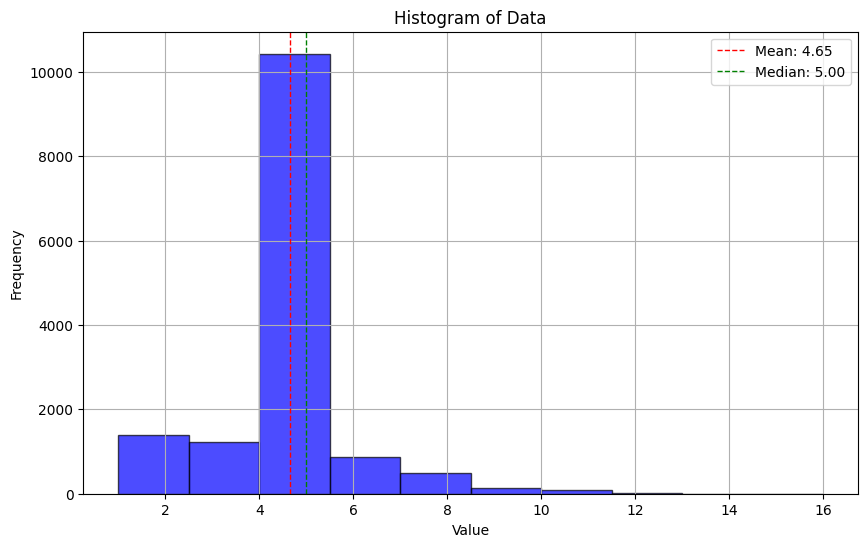

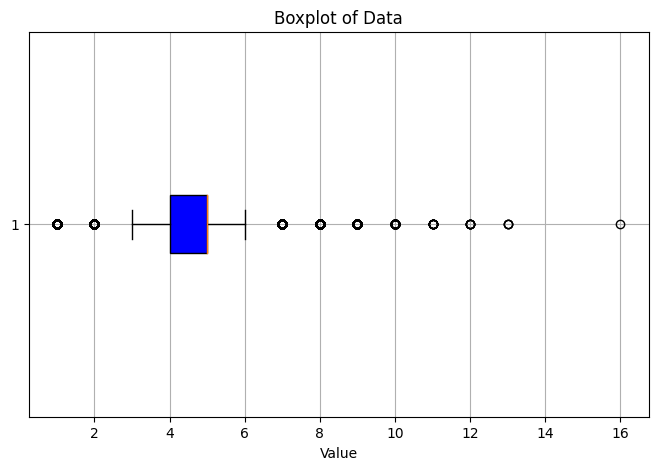

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Example data list
data = len_count_nonzero

# Calculate basic statistics
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)
variance = np.var(data)
minimum = np.min(data)
maximum = np.max(data)
percentiles = np.percentile(data, [25, 50, 75])  # 25th, 50th (median), and 75th percentiles

# Print the statistical analysis
print("Statistical Analysis:")
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {std_dev}")
print(f"Variance: {variance}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")
print(f"25th, 50th, 75th Percentiles: {percentiles}")

# Visualization: Histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f"Mean: {mean:.2f}")
plt.axvline(median, color='green', linestyle='dashed', linewidth=1, label=f"Median: {median:.2f}")
plt.title("Histogram of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor='blue', color='black'))
plt.title("Boxplot of Data")
plt.xlabel("Value")
plt.grid(True)
plt.show()
